In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from astropy.modeling import models, fitting

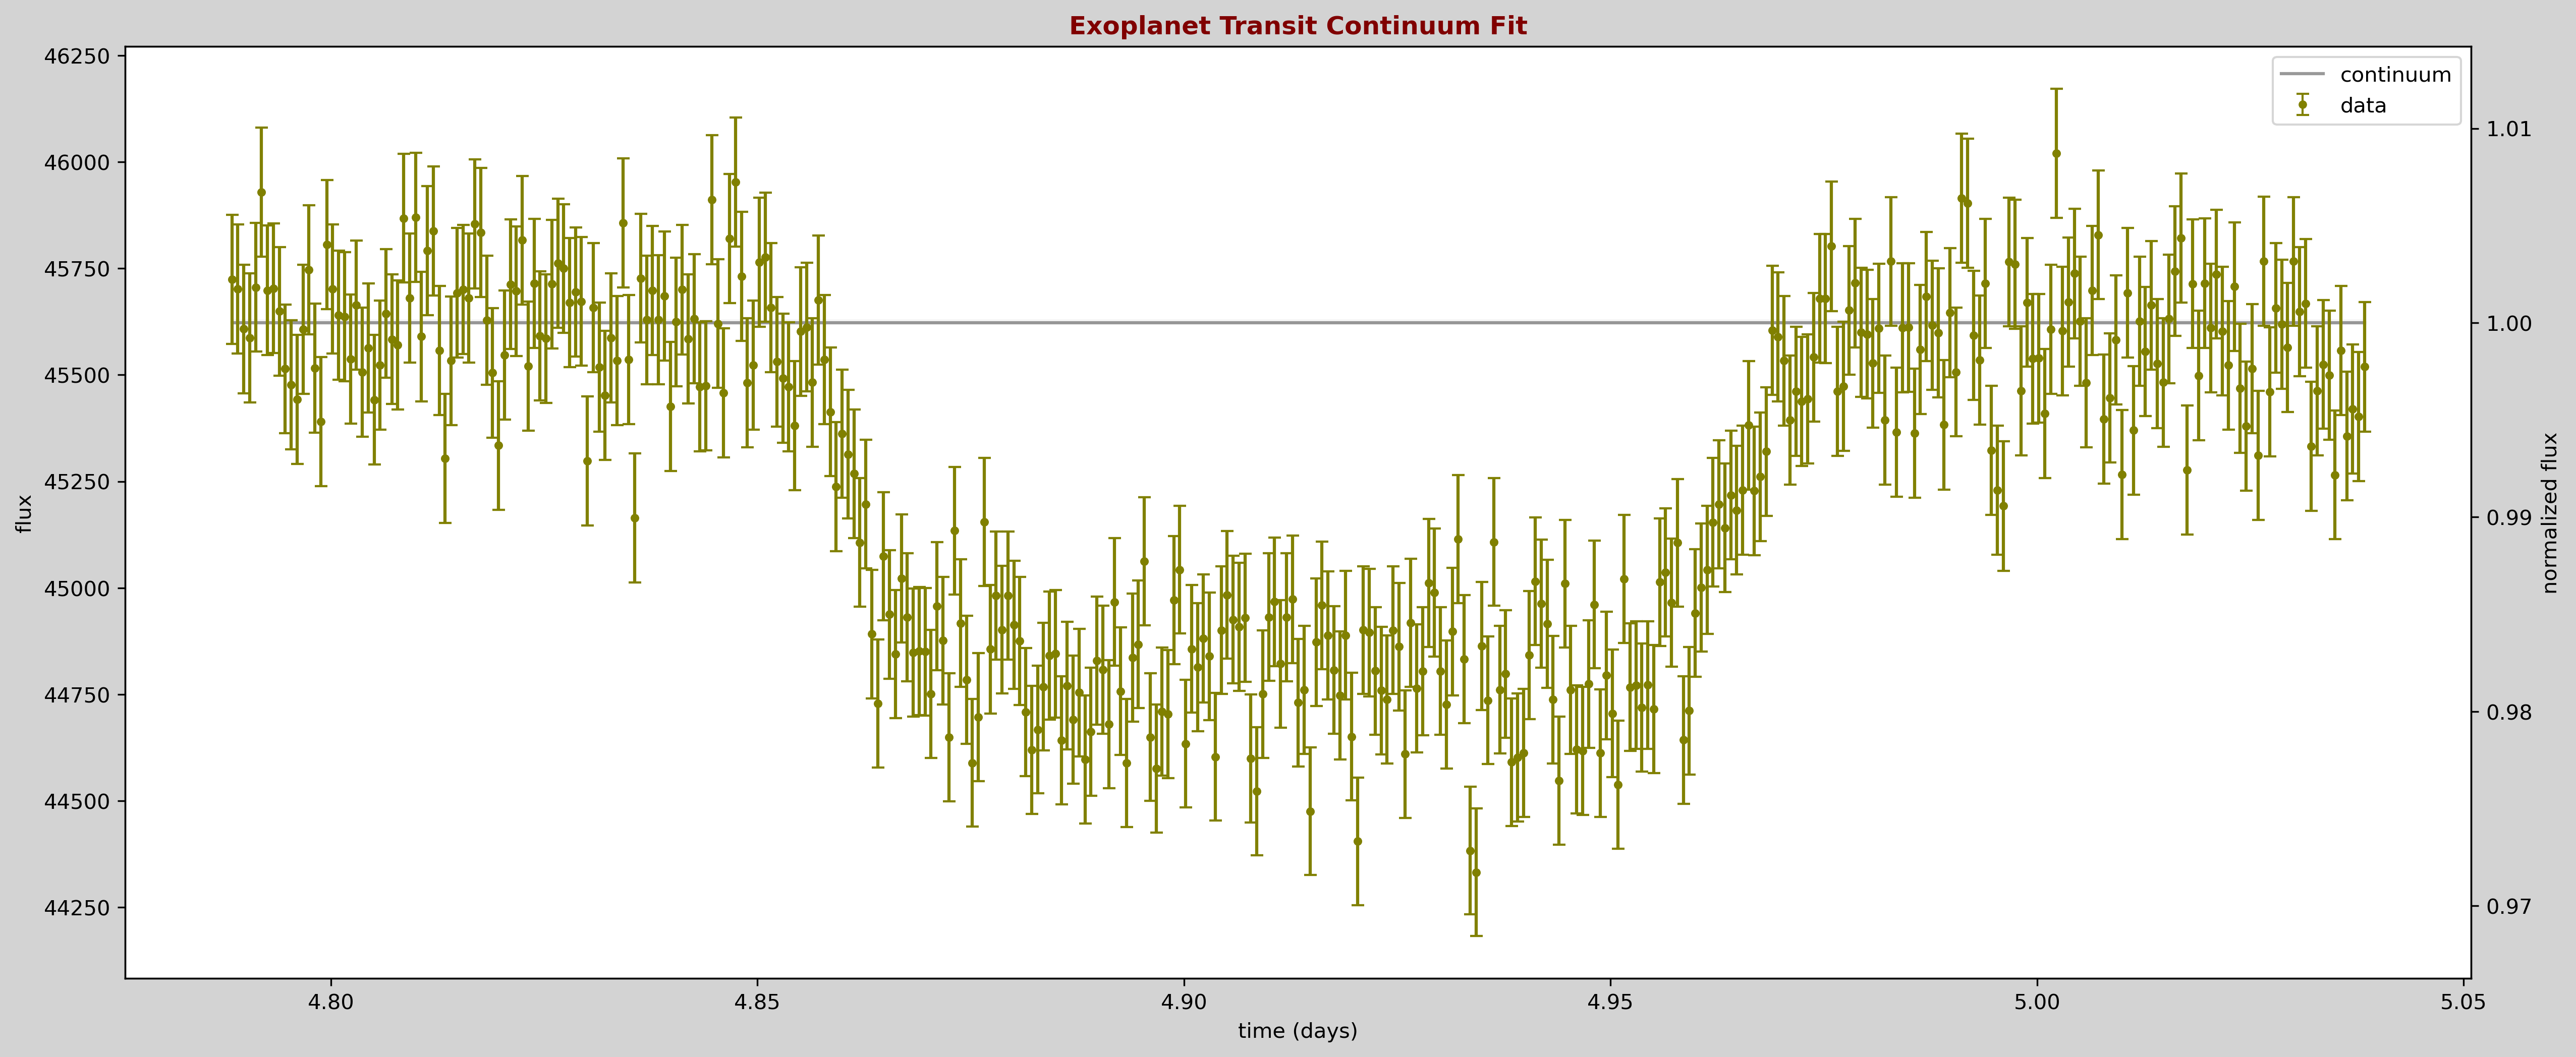

good guess; reduced chi^2: 1.045


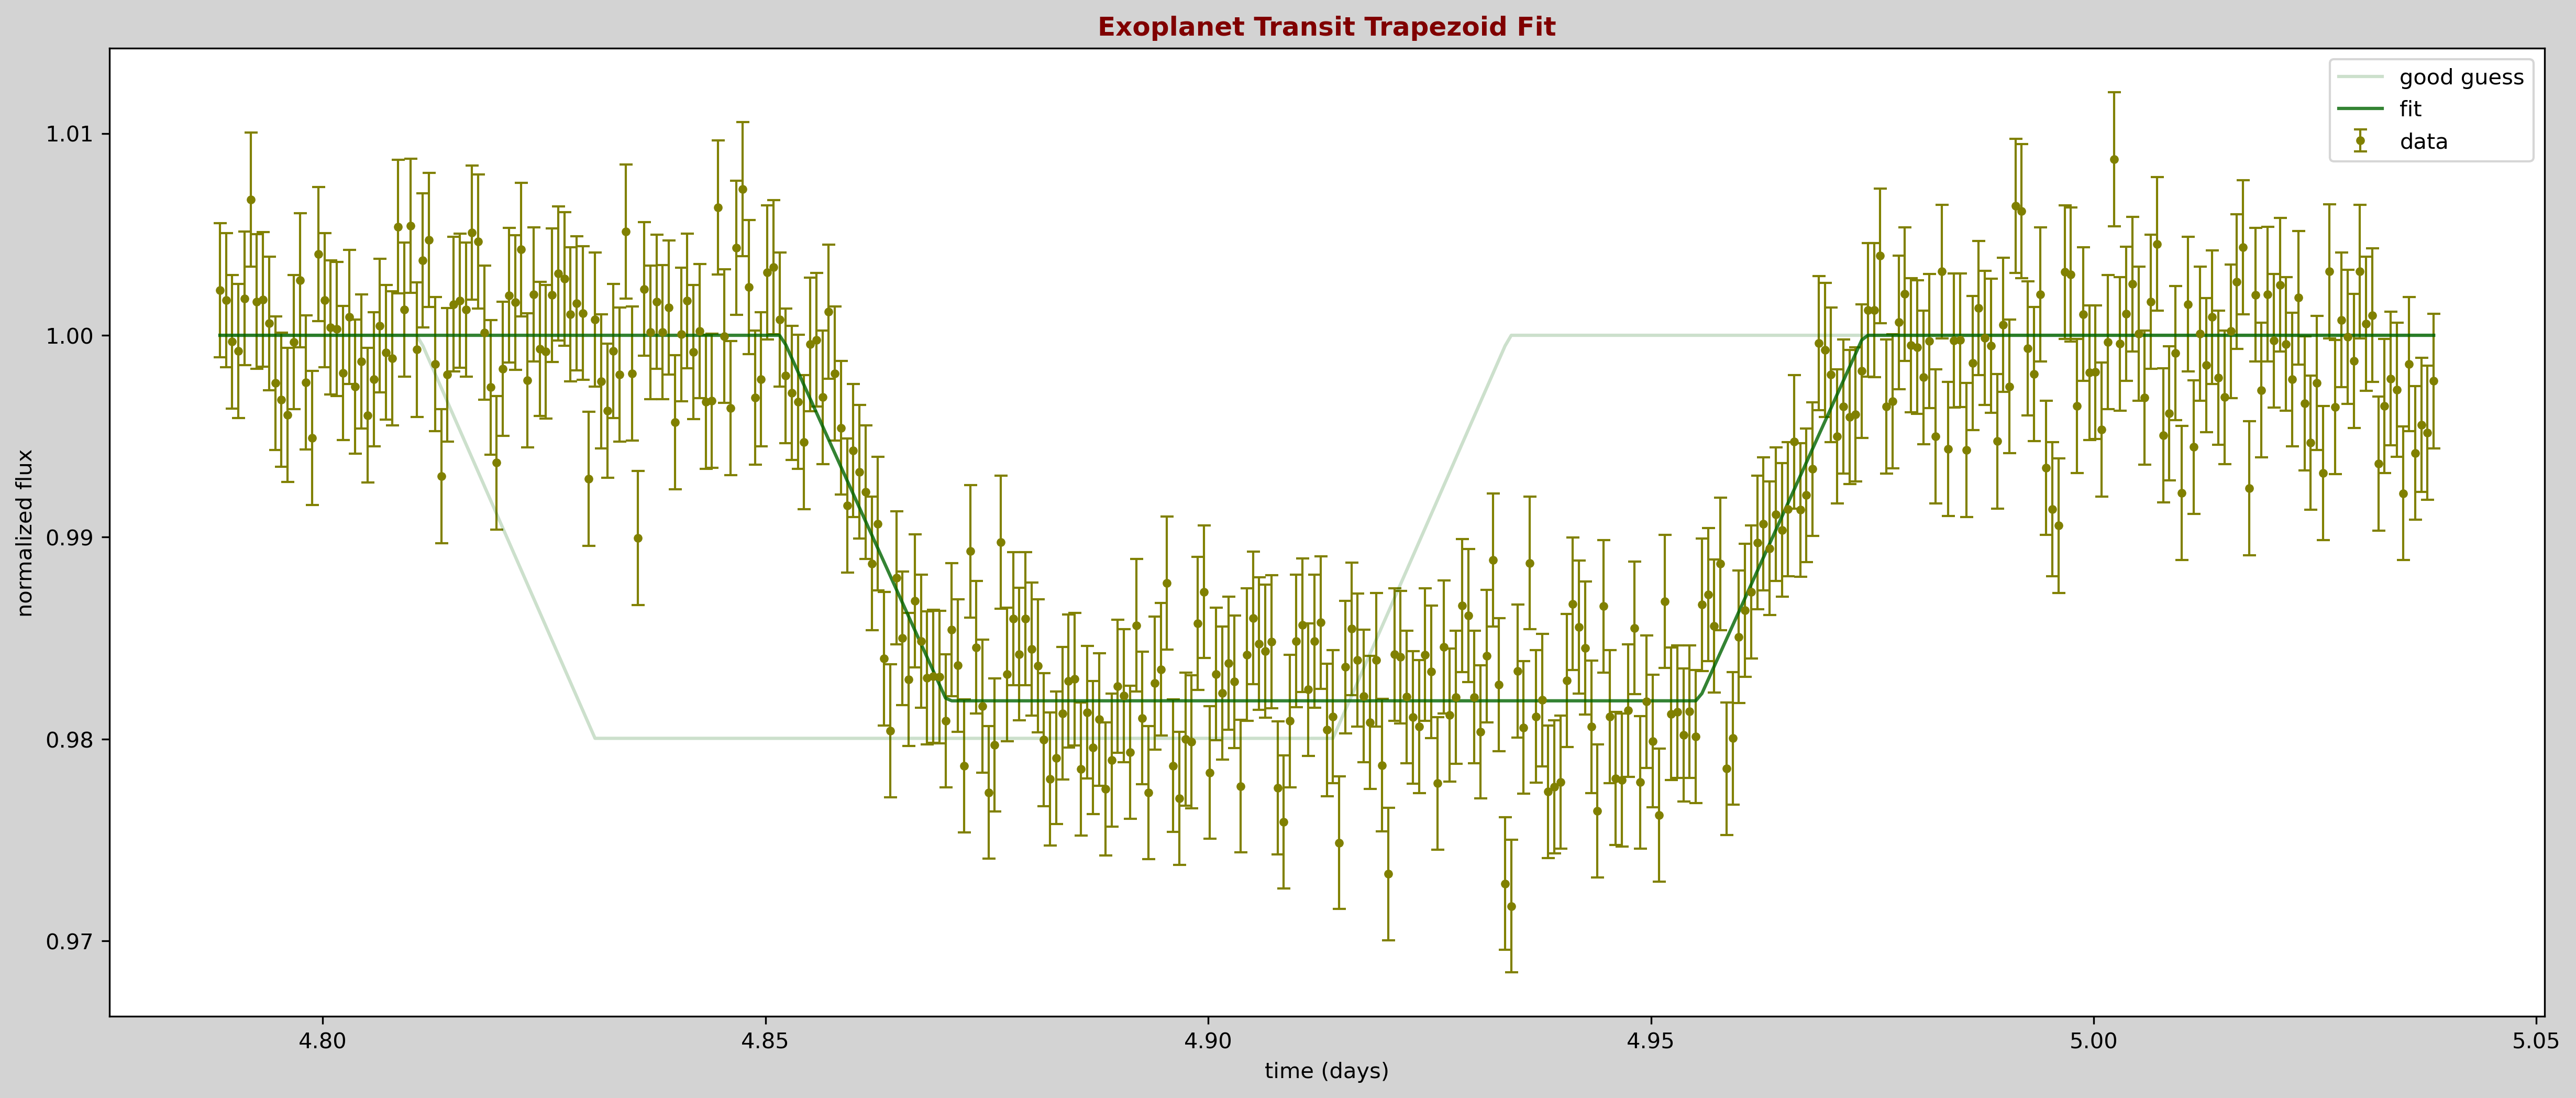

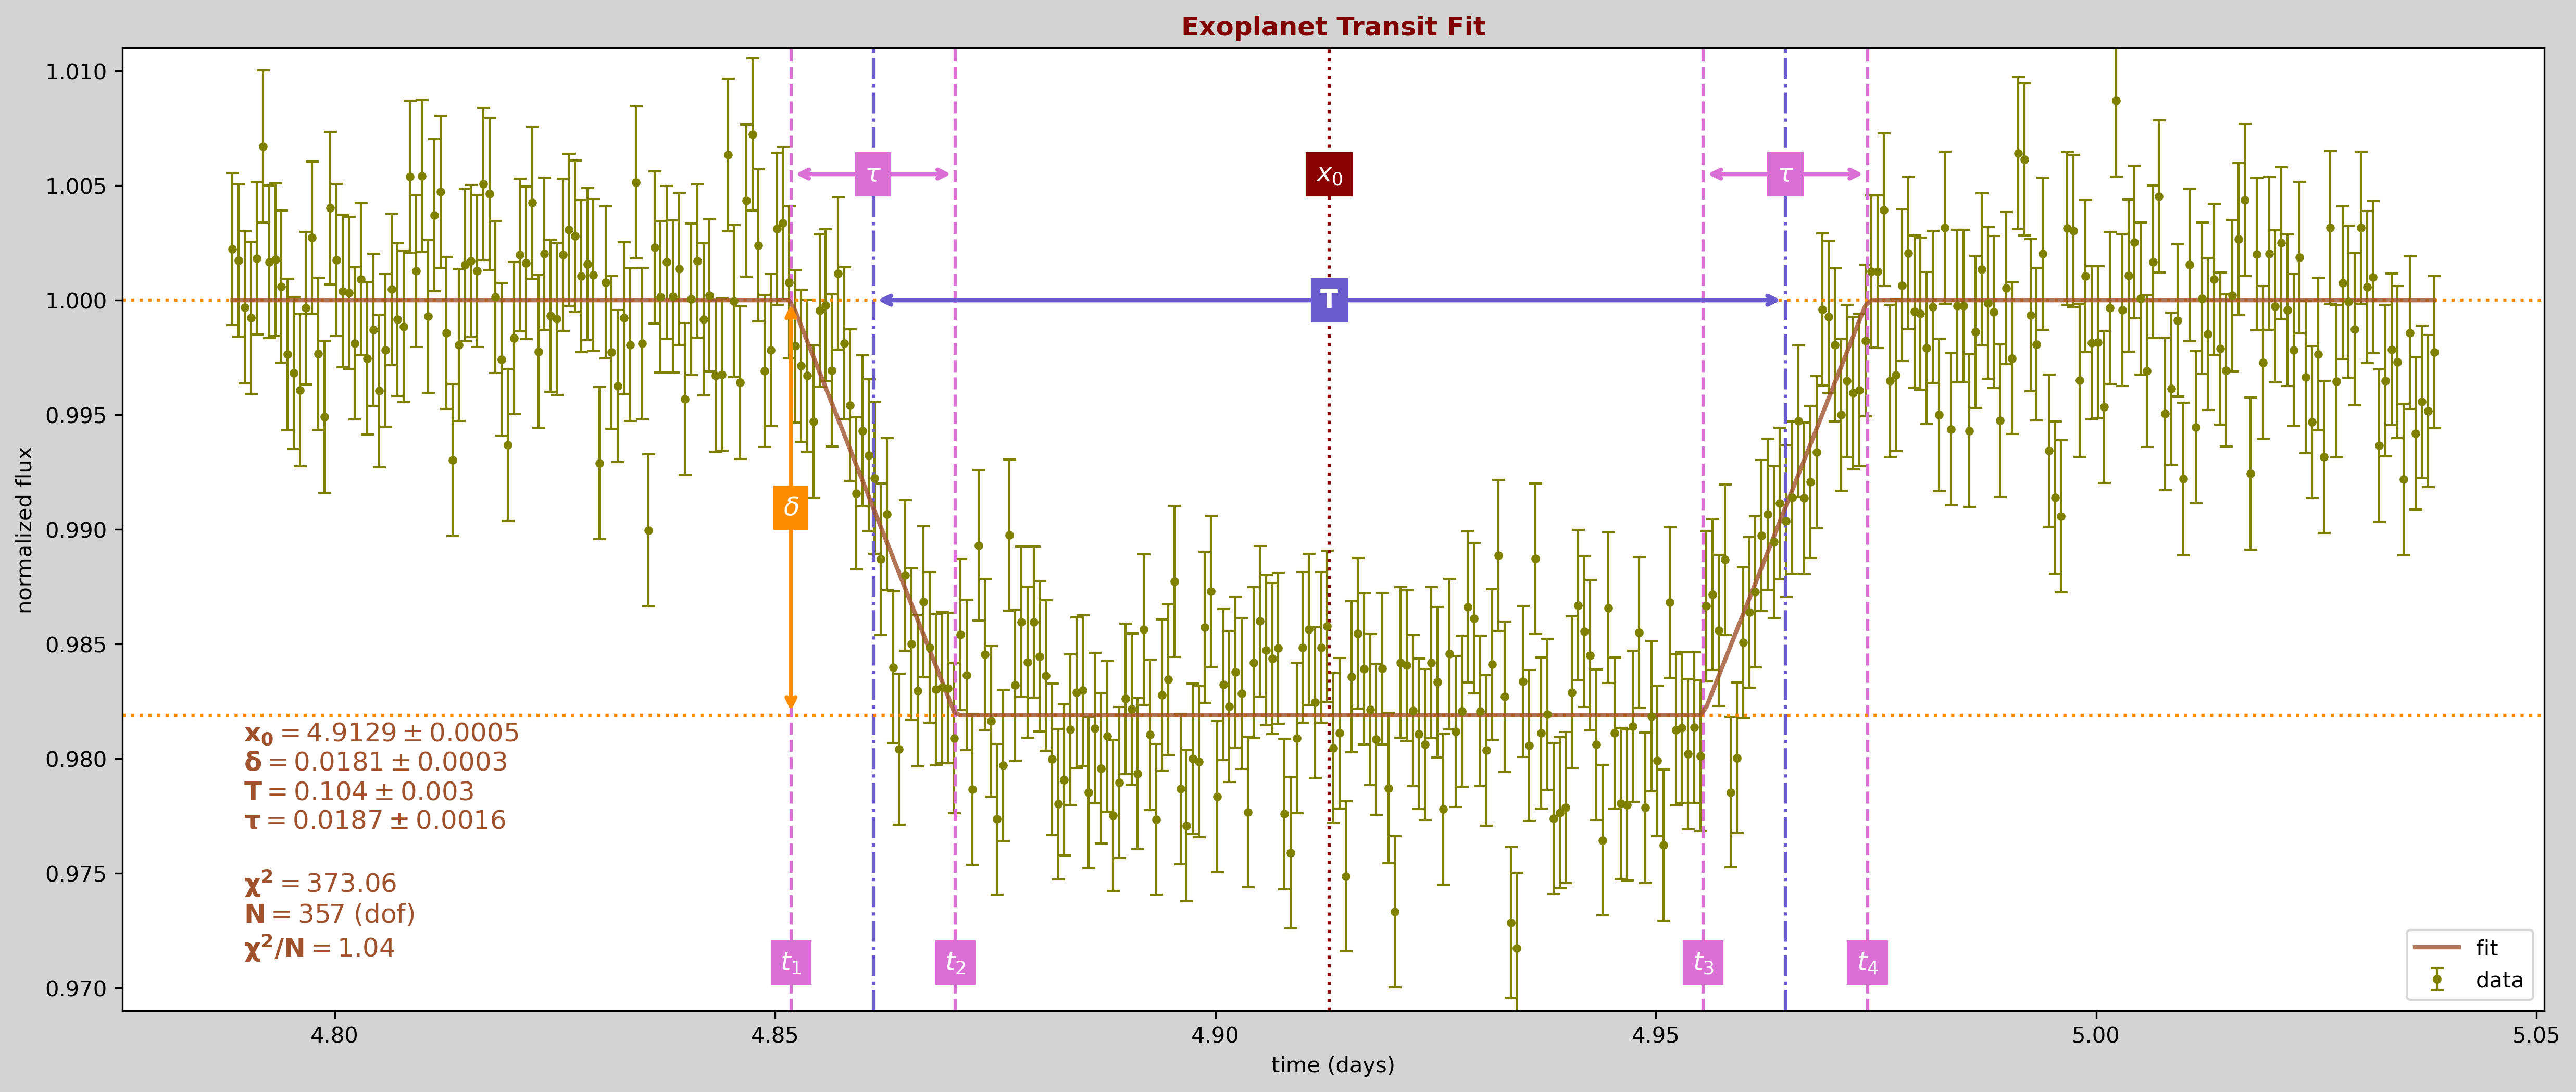

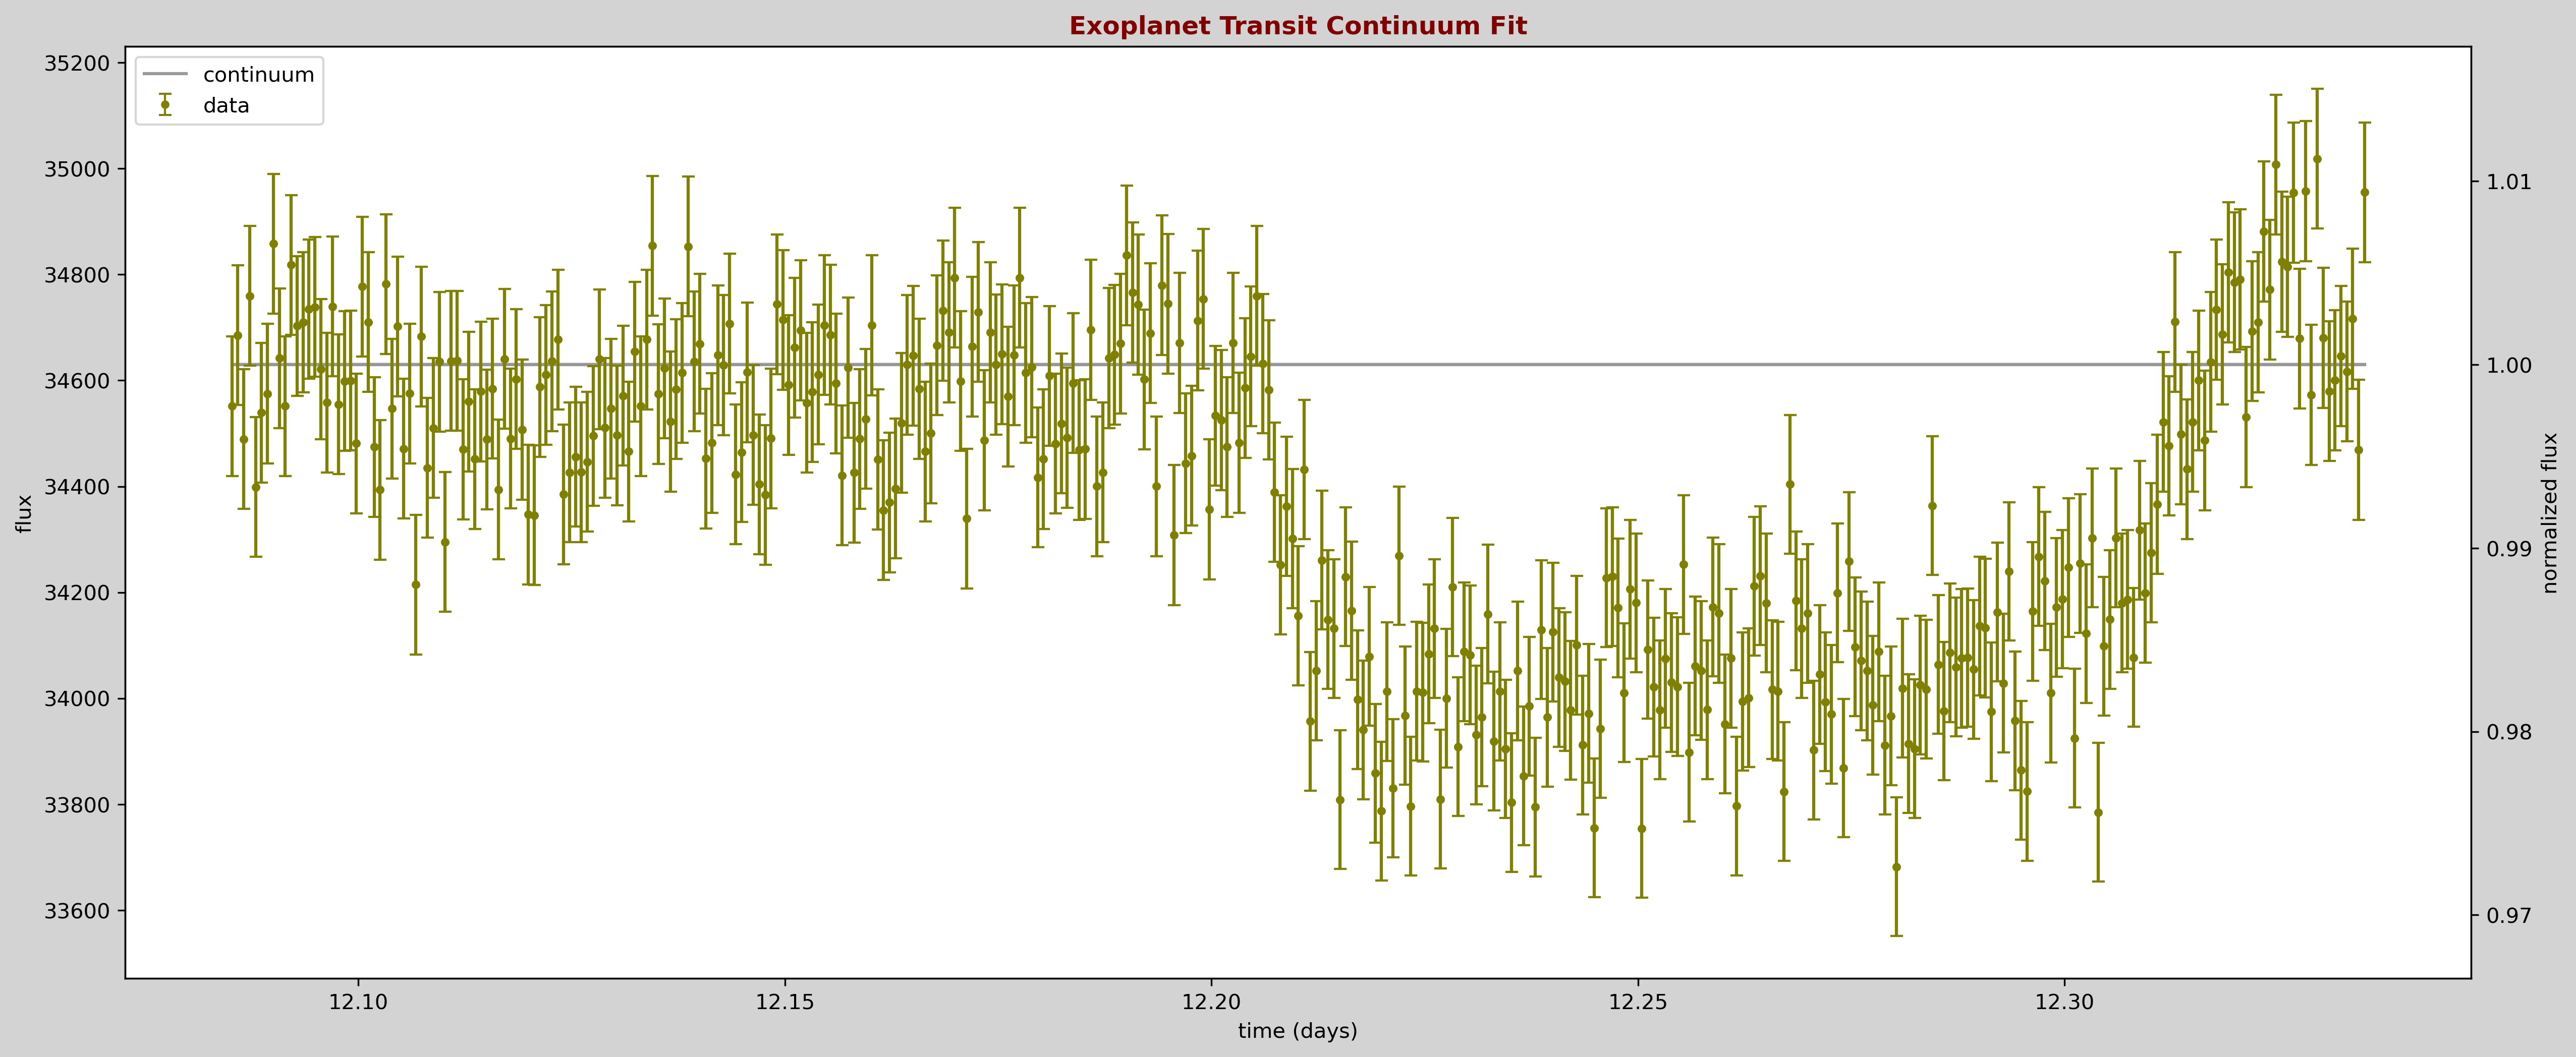

bad guess
bad guess
bad guess
bad guess
bad guess
bad guess
bad guess
bad guess
good guess; reduced chi^2: 1.164


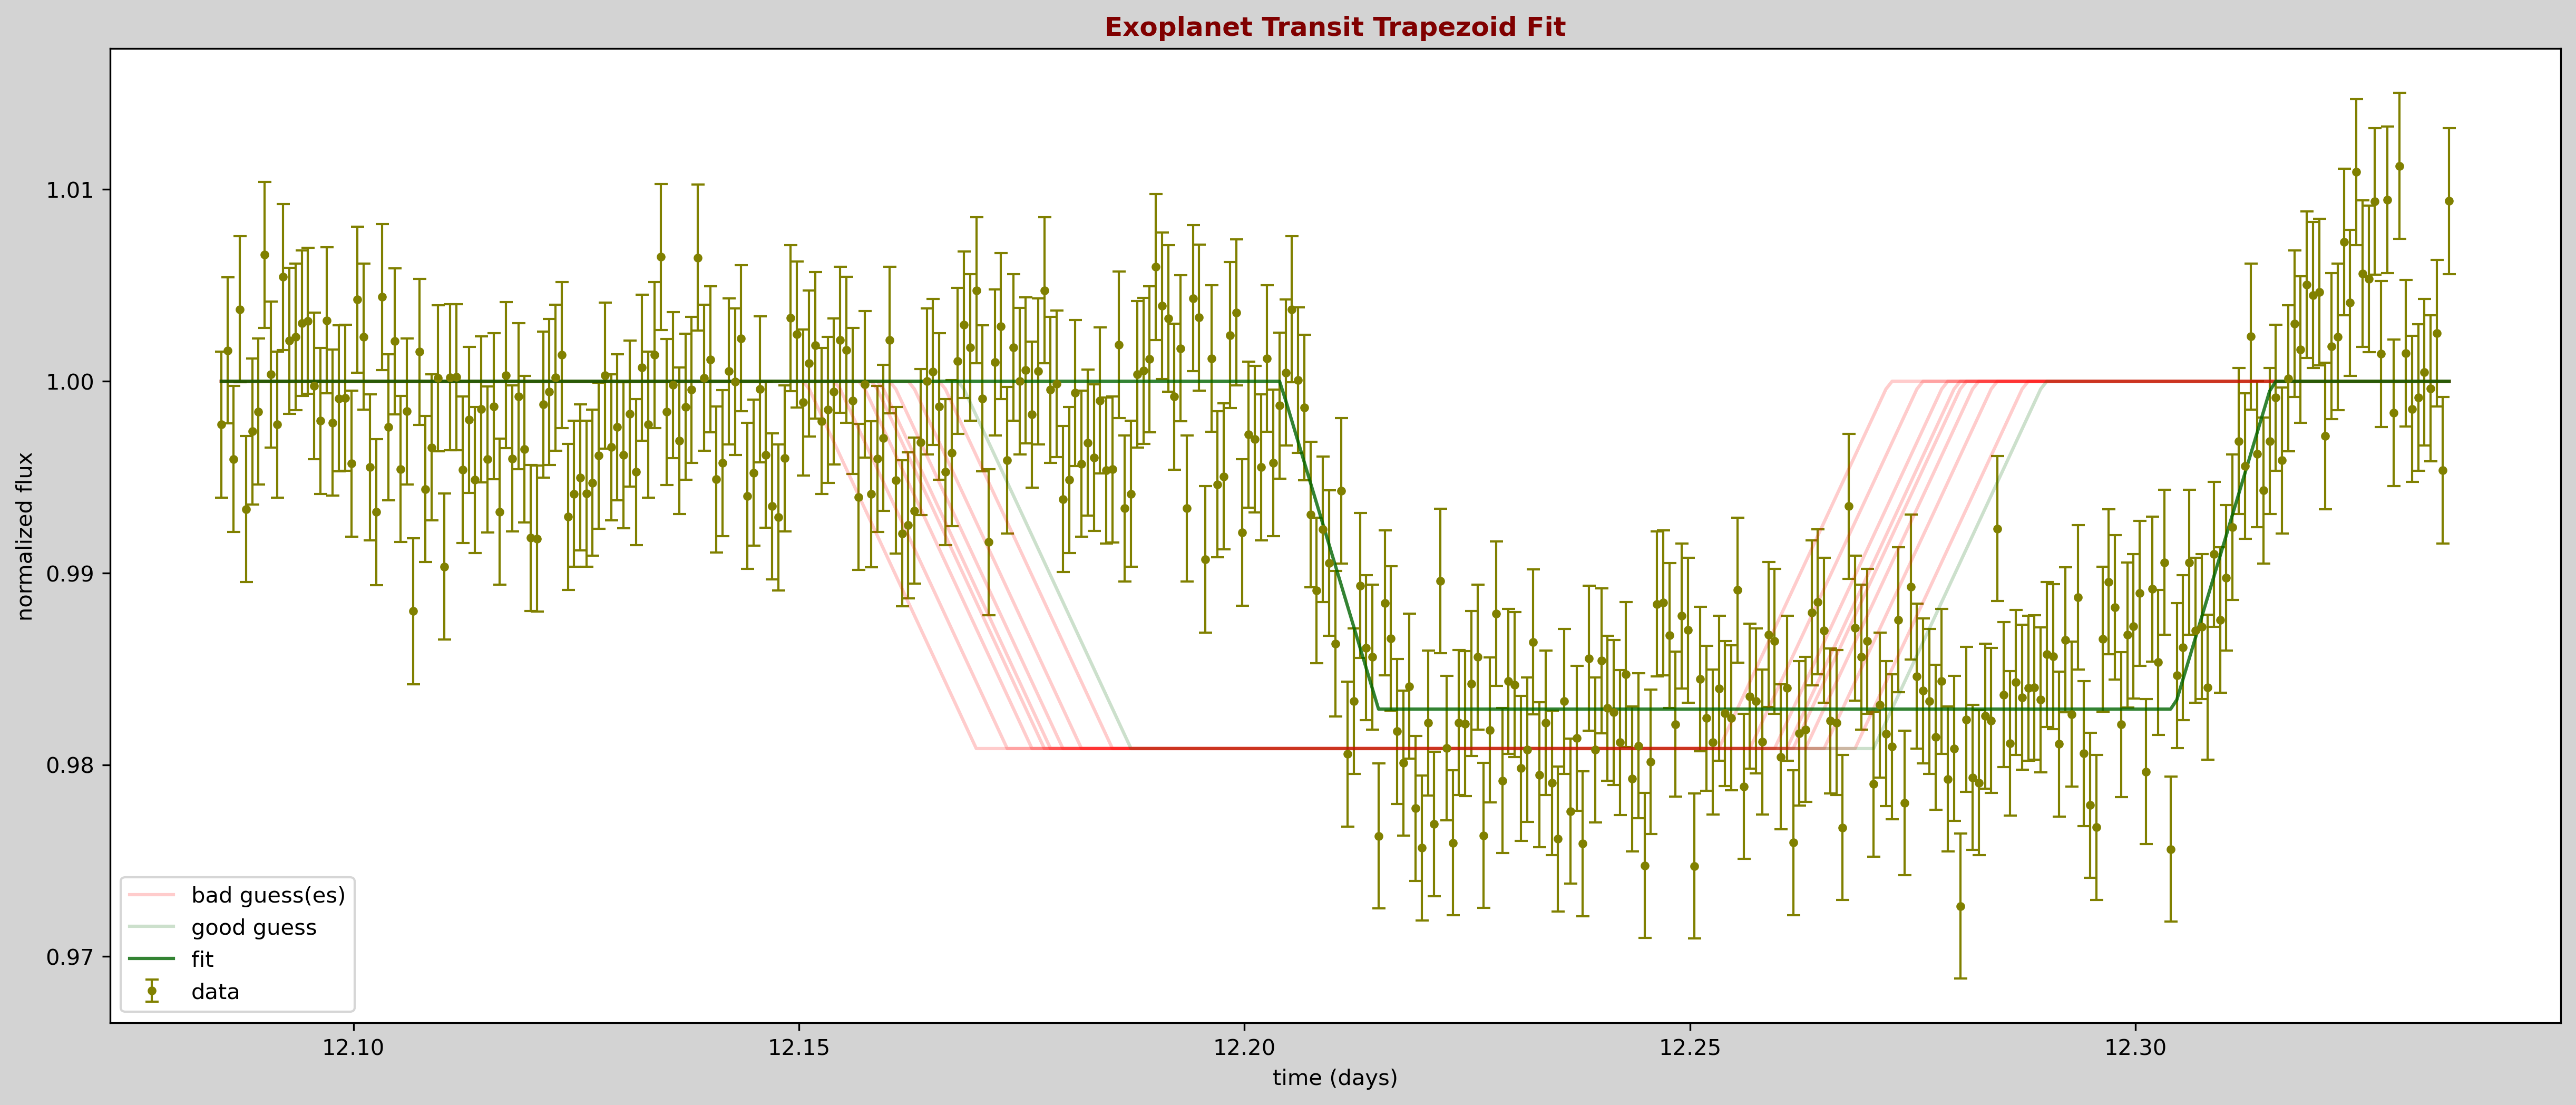

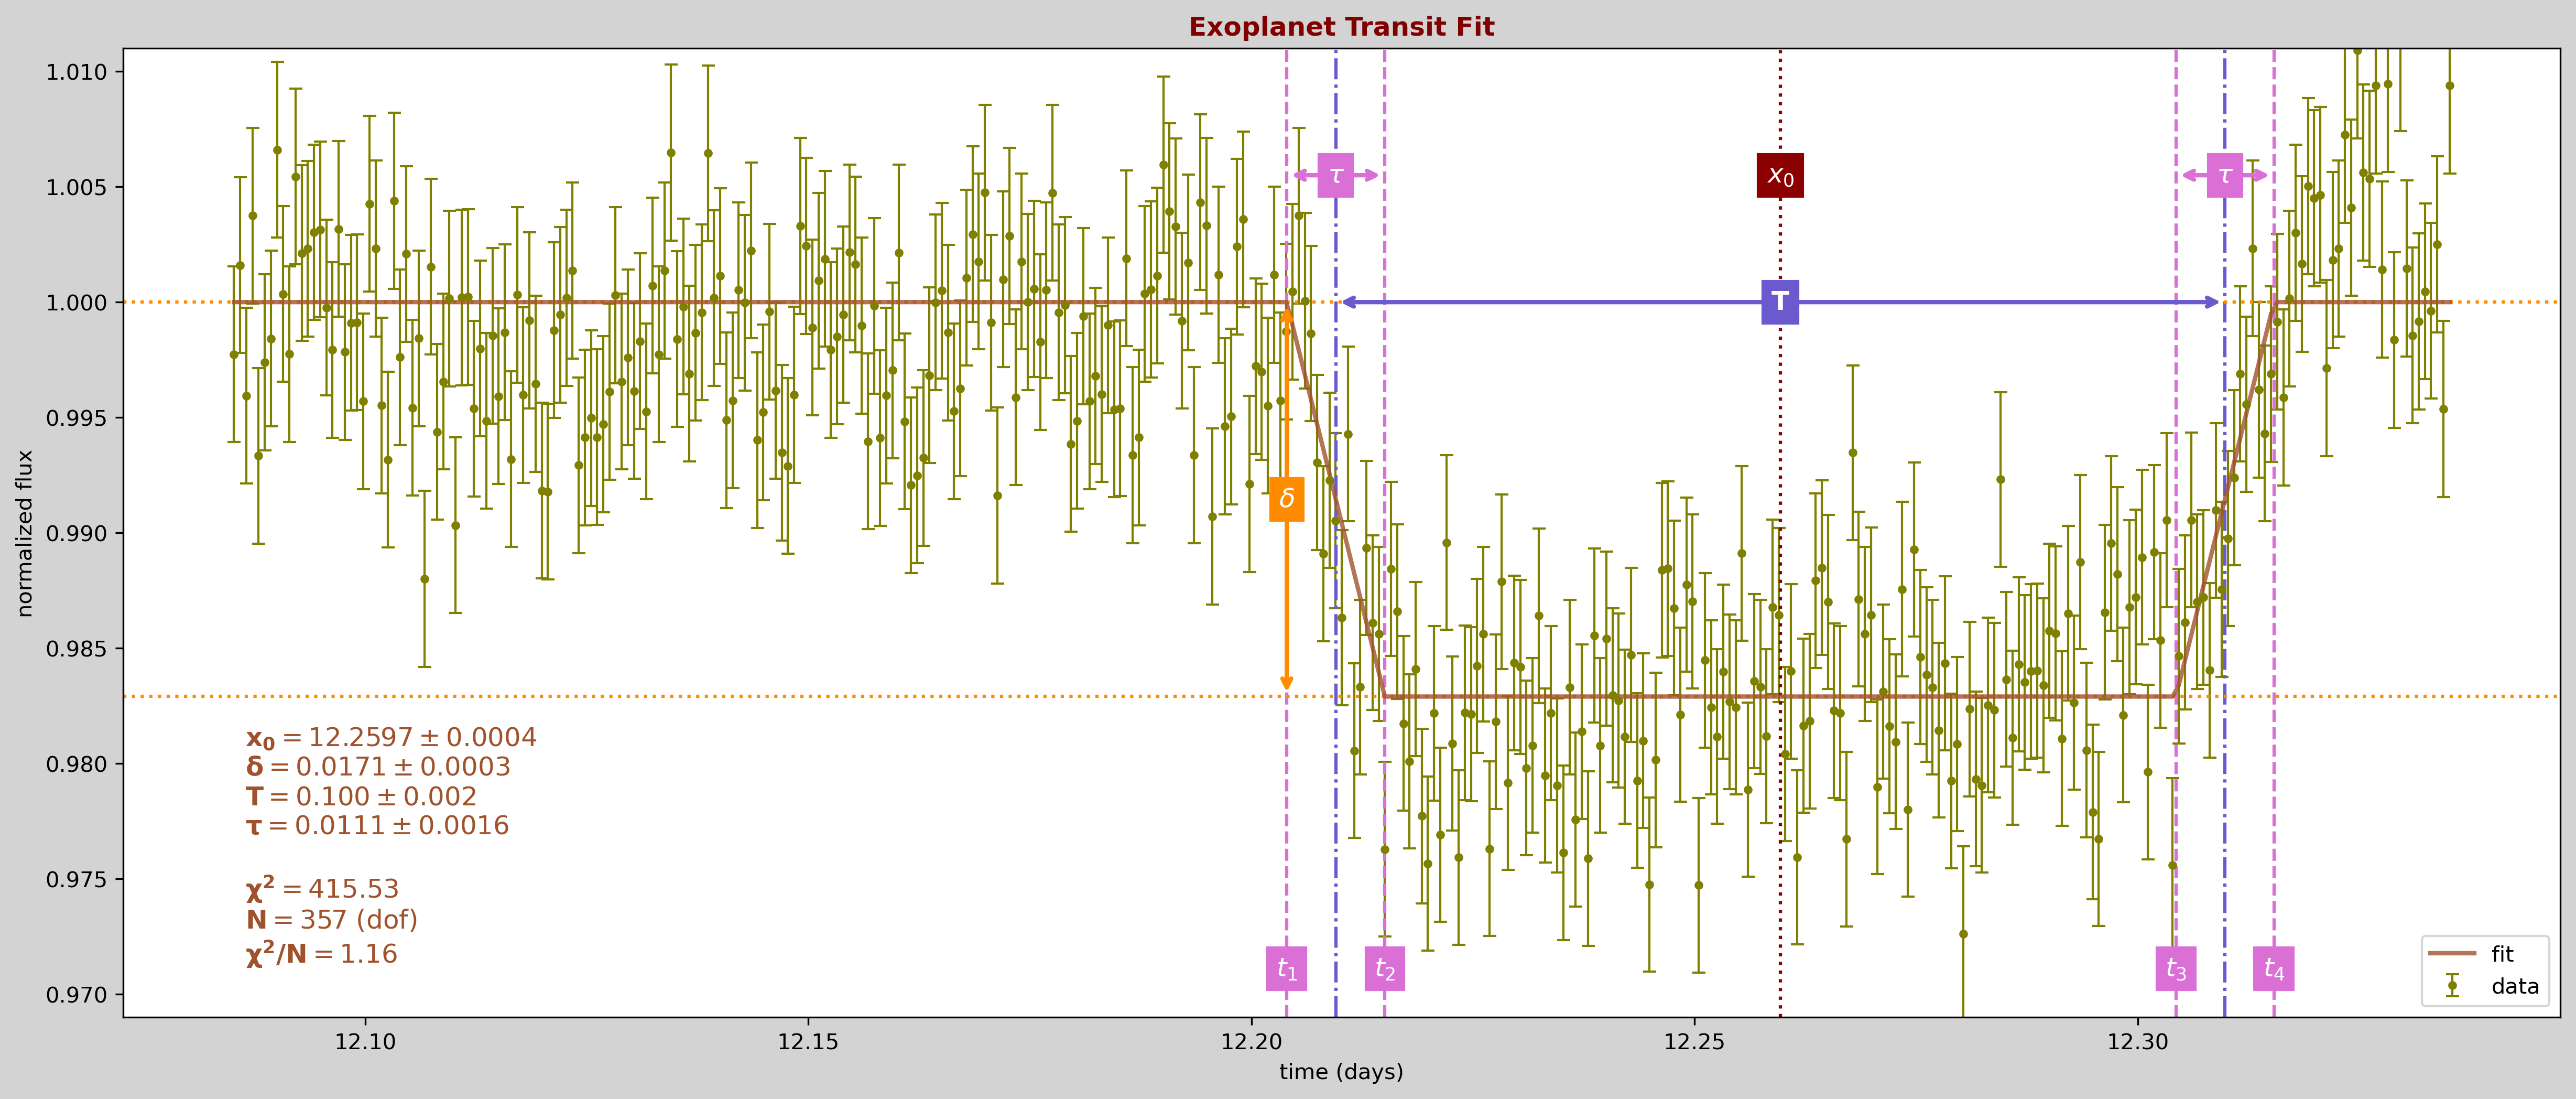

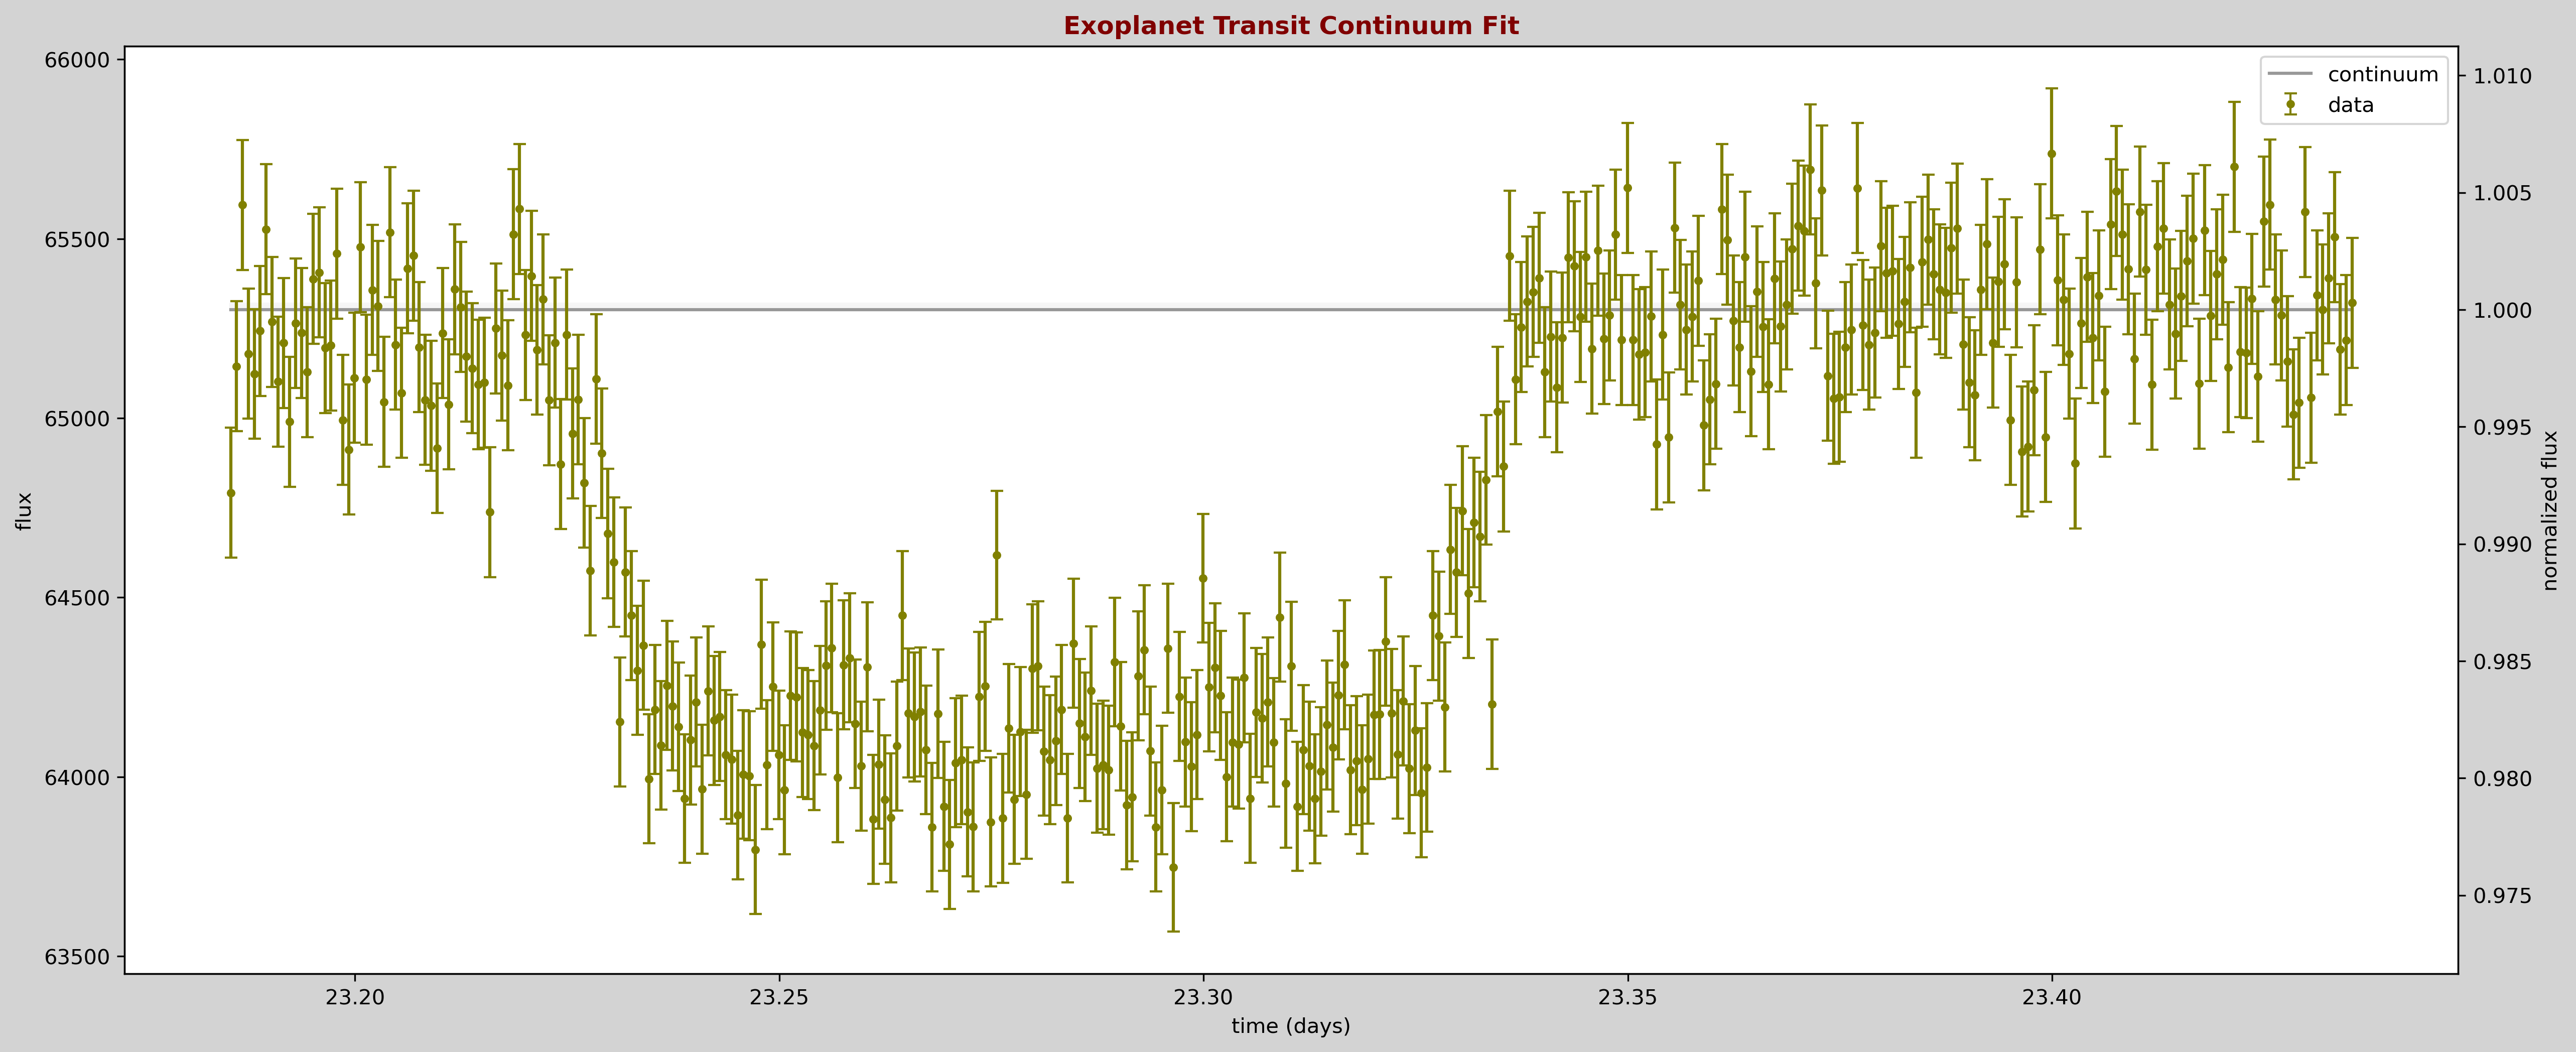

bad guess
good guess; reduced chi^2: 1.017


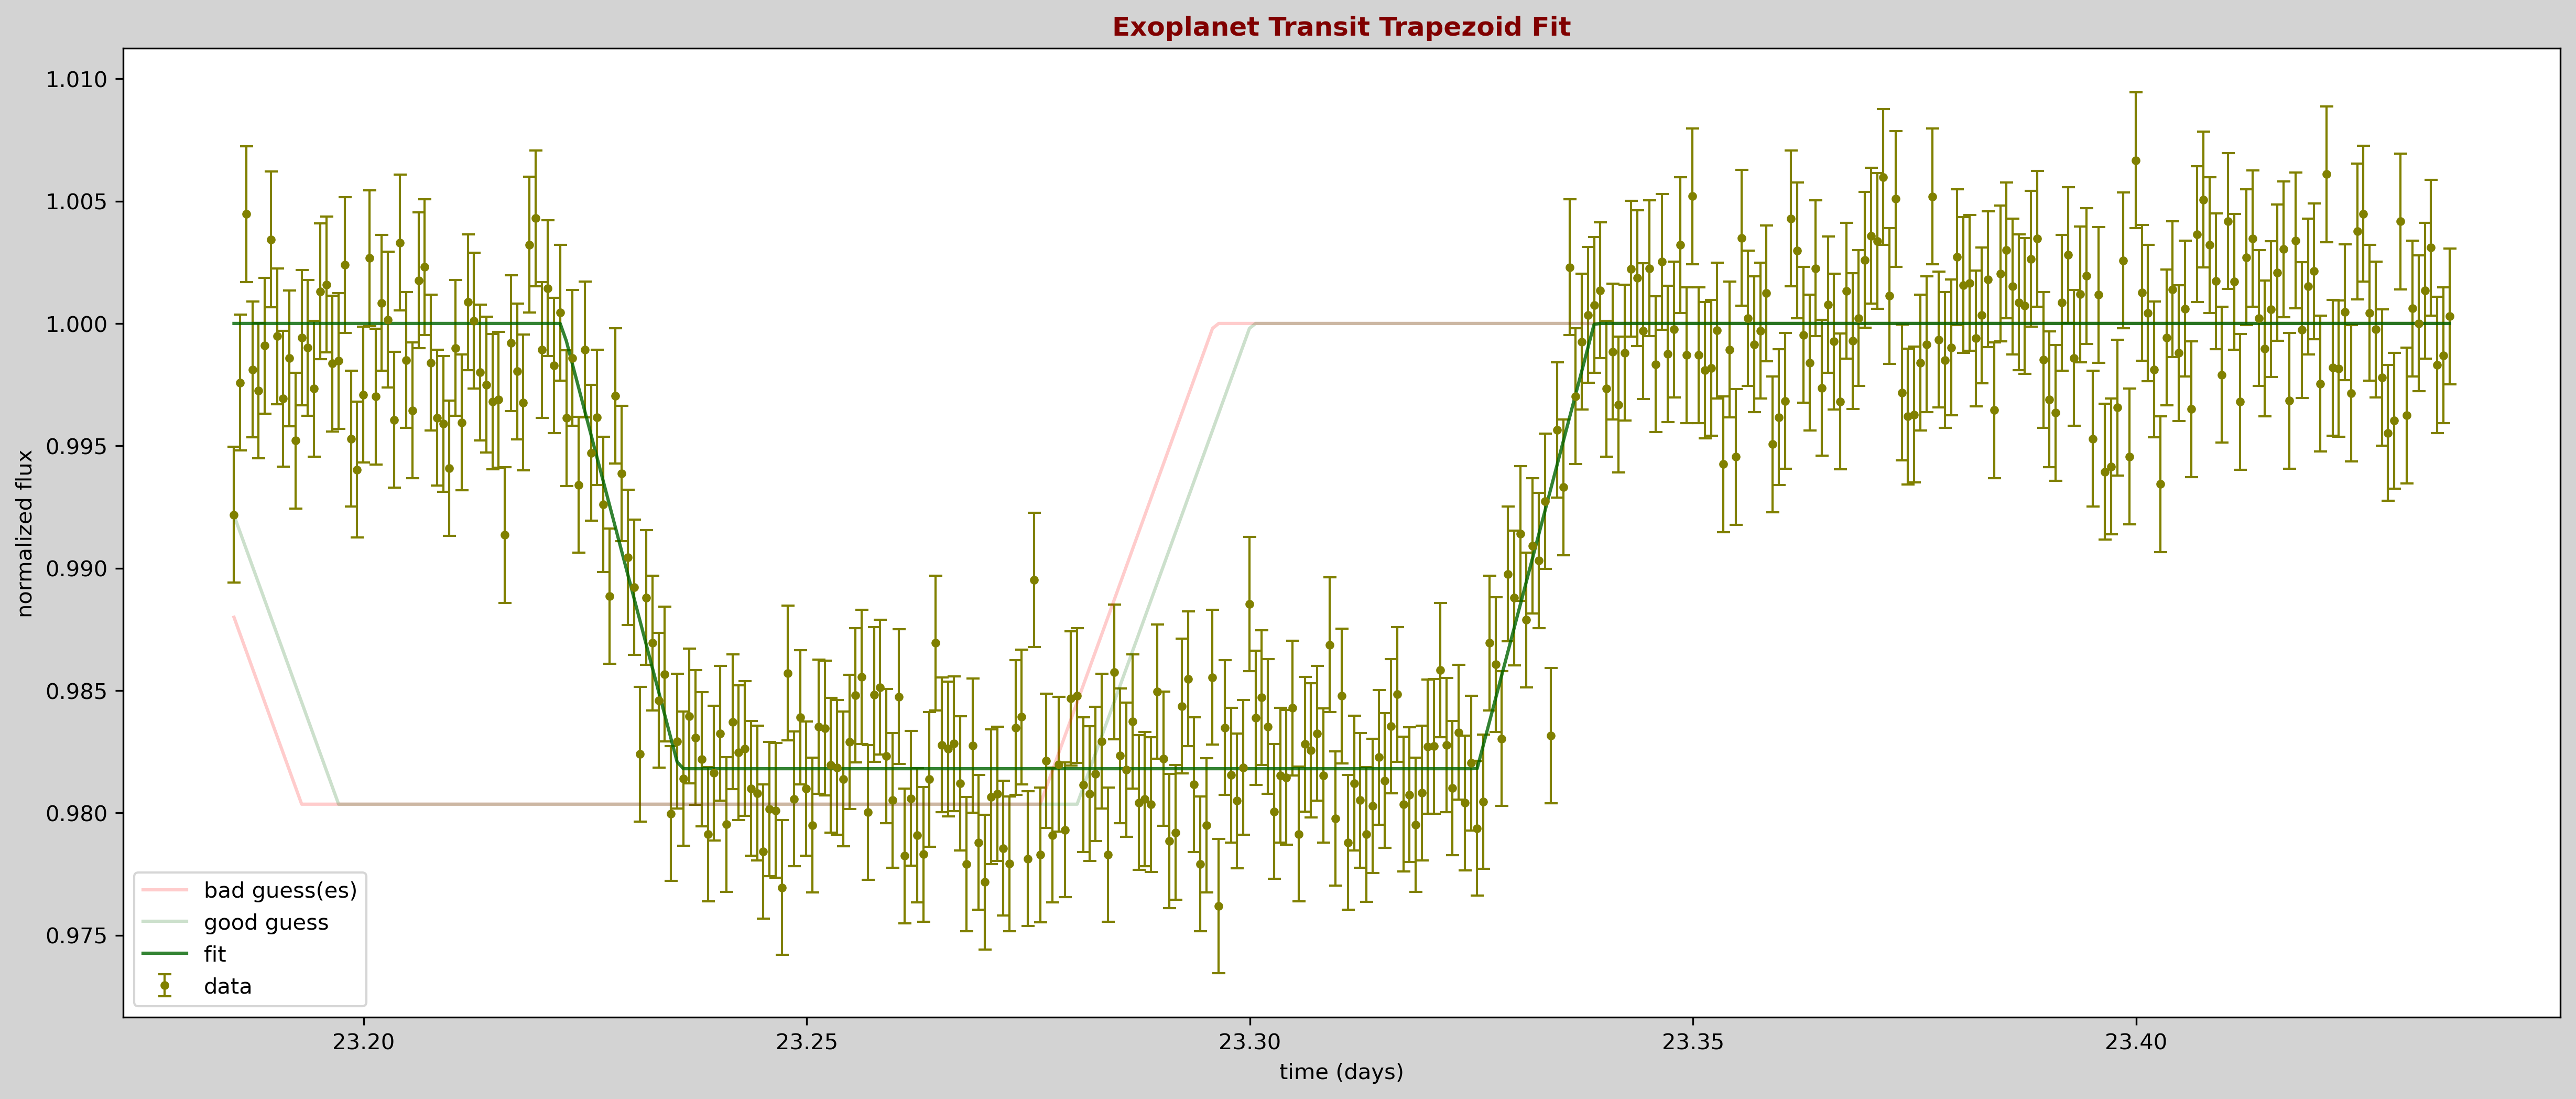

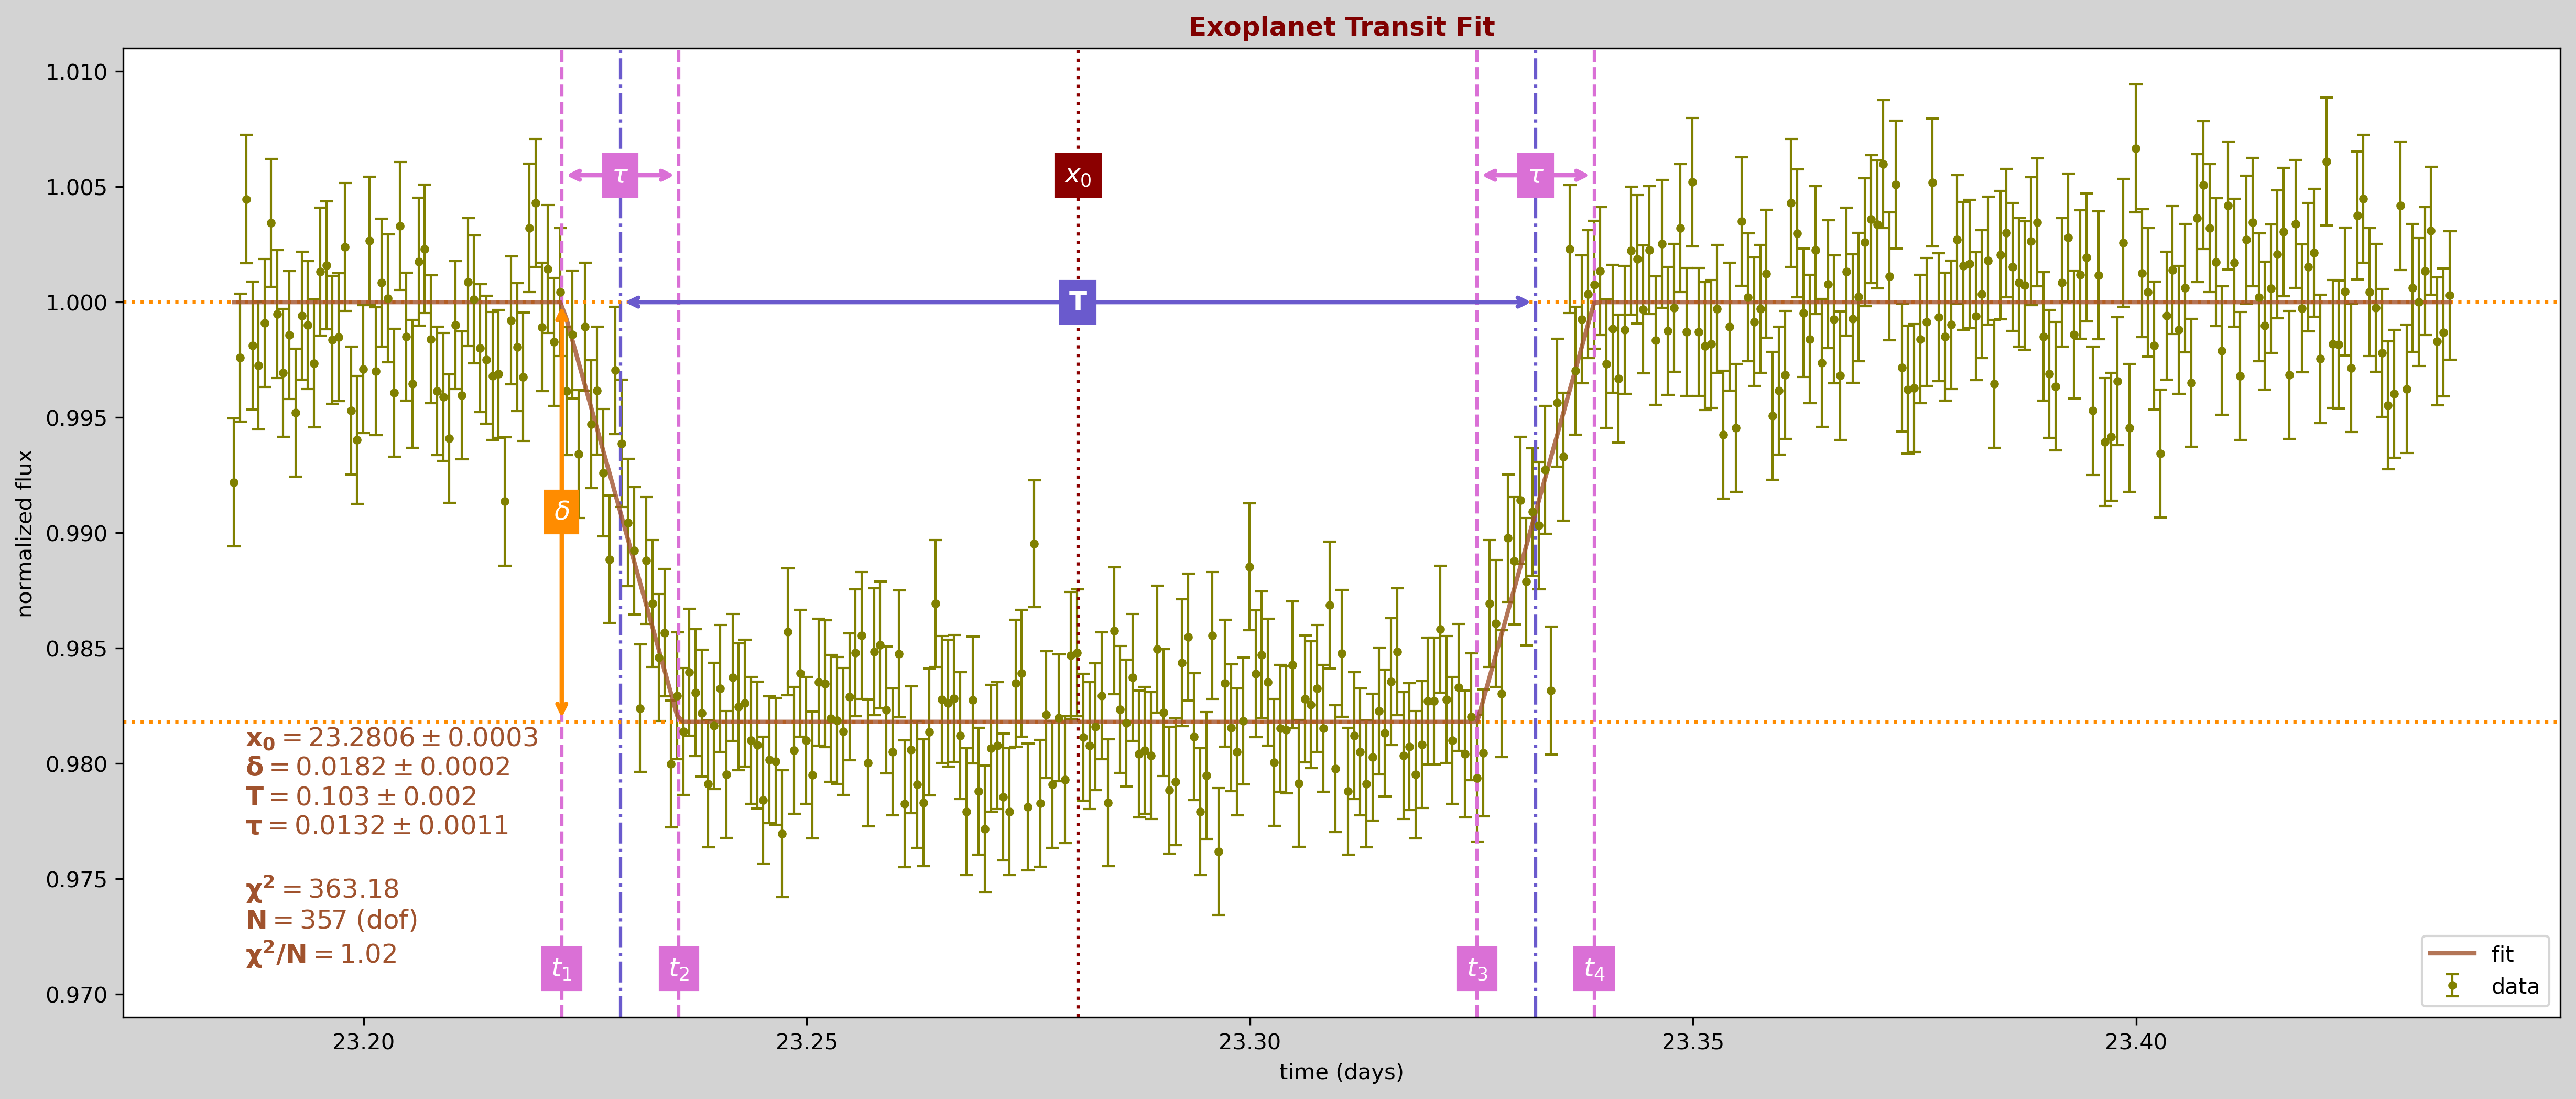

In [2]:
# separate analyses
# will capture the best-fit trapezoid centers to shift

centers = []
centers_err = []
norms = []
for filename in ["hw3_prob1_data1.txt","hw3_prob1_data2.txt","hw3_prob1_data3.txt"]:
    time,flux,uncertainty = np.loadtxt(filename,skiprows=2).T
    
    
    fig,ax = plt.subplots(figsize = (20,8), dpi=300)
    fig.set_facecolor("lightgray")
    ax.set_title("Exoplanet Transit Continuum Fit",color="maroon",weight="bold")
    ax.set_xlabel("time (days)")
    ax.set_ylabel("flux")
    ax.errorbar(time,flux,yerr=uncertainty,capsize=3,marker=".",ls='none',color="olive",label="data",lw=1)
    
    # recursive strategy to fit continuum
    iterations = 3
    mask = flux>np.percentile(flux,50)
    for i in range(iterations):
        fit = np.polyfit(time[mask],flux[mask],0)
        x_s = np.linspace(np.min(time),np.max(time),100)
        plt.plot(x_s,np.poly1d(fit)(x_s),color="lightgray",alpha=0.2)
    
        err = np.poly1d(fit)(time[mask])-flux[mask]
        mask = (flux<(fit[0]+np.std(err)))&((flux>(fit[0]-np.std(err))))
    continuum = fit[0]
    ax.plot(x_s,np.poly1d(fit)(x_s),color="gray",alpha=0.8,label="continuum")
    ax.legend()
    
    flux = flux/continuum
    uncertainty = uncertainty/continuum
    
    ax1 = ax.twinx()
    ax1.set_ylabel("normalized flux")
    ax1.errorbar(time,flux,yerr=uncertainty,capsize=3,marker=".",ls='none',color="olive")
    plt.show()





    fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)
    
    inv_flux = -1*flux+1
    
    fig,ax = plt.subplots(figsize = (20,8), dpi=300)
    fig.set_facecolor("lightgray")
    ax.set_title("Exoplanet Transit Trapezoid Fit",color="maroon",weight="bold")
    ax.set_xlabel("time (days)")
    ax.set_ylabel("normalized flux")
    ax.errorbar(time,-1*(inv_flux-1),yerr=uncertainty,capsize=3,marker=".",ls='none',color="olive",label="data",lw=1)
    # x0 seems to affect the fitting badly. iterate until it fits well
    x0s = time[inv_flux>np.percentile(inv_flux,90)]
    i = 0
    red_chi2 = 10
    cutoff = 1.5
    labeled = False
    while red_chi2 > cutoff and i < (len(x0s)):
        try:
            t_init = models.Trapezoid1D(amplitude=np.percentile(inv_flux,90),
                                        x_0=x0s[i],
                                        width=(np.max(time)-np.min(time))/3,
                                        slope=1)
    
            t = fitter(t_init,time,inv_flux,weights=1/uncertainty)
            errs = np.sqrt(np.diagonal(fitter.fit_info["cov_x"]))
    
            chi2 = np.sum(((t(time)-inv_flux)/uncertainty)**2)
            dof = len(time) - len(errs)
            red_chi2 = chi2/dof
            print(f"good guess; reduced chi^2: {red_chi2:.3f}")
            ax.plot(time,-1*(t_init(time)-1),color="darkgreen",alpha=0.2,label="good guess")
        except:
            print("bad guess")
            if labeled:
                ax.plot(time,-1*(t_init(time)-1),color="red",alpha=0.2)
            else:
                ax.plot(time,-1*(t_init(time)-1),color="red",alpha=0.2,label="bad guess(es)")
                labeled = True
    
        i += 1
    
    ax.plot(time,-1*(t(time)-1),color="darkgreen",alpha=0.8,label="fit")
    ax.legend()
    plt.show()




    fig,ax = plt.subplots(figsize = (20,8), dpi=300)
    fig.set_facecolor("lightgray")
    ax.set_title("Exoplanet Transit Fit",color="maroon",weight="bold")
    ax.set_xlabel("time (days)")
    ax.set_ylabel("normalized flux")
    ax.set_ylim(0.969,1.011)
    ax.errorbar(time,-1*(inv_flux-1),yerr=uncertainty,capsize=3,marker=".",ls='none',color="olive",label="data",lw=1)
    
    ax.annotate('',xy=(t.x_0-t.width/2-t.amplitude/2*1/t.slope,1),xycoords='data',
    				xytext=(t.x_0+t.width/2+t.amplitude/2*1/t.slope,1),textcoords='data',
    				arrowprops=dict(color="slateblue",lw=2,arrowstyle="<->"),va='center')
    ax.annotate('T',xy=(t.x_0*1.,1),xycoords='data',size=12,color="white",weight="bold",
                textcoords='data',ha="center",va="center",backgroundcolor="slateblue")
    ax.axvline(t.x_0-t.width/2-t.amplitude/2*1/t.slope,color="slateblue",ls="-.")
    ax.axvline(t.x_0+t.width/2+t.amplitude/2*1/t.slope,color="slateblue",ls="-.")

    ax.axvline(t.x_0[0],color="darkred",ls=":")
    ax.annotate('$x_0$',xy=(t.x_0[0],1+(ax.get_ylim()[-1]-1)/2),xycoords='data',size=12,color="white",weight="bold",
                textcoords='data',ha="center",va="center",backgroundcolor="darkred")
    
    ax.annotate('',xy=(t.x_0-t.width/2-t.amplitude*1/t.slope,1+(ax.get_ylim()[-1]-1)/2),xycoords='data',
    				xytext=(t.x_0-t.width/2,1+(ax.get_ylim()[-1]-1)/2),textcoords='data',
    				arrowprops=dict(color="orchid",lw=2,arrowstyle="<->"),va='center')
    ax.annotate('$\\tau$',xy=(t.x_0-t.width/2-t.amplitude/2*1/t.slope,1+(ax.get_ylim()[-1]-1)/2),xycoords='data',size=12,color="white",weight="bold",
                textcoords='data',ha="center",va="center",backgroundcolor="orchid")
    ax.annotate('',xy=(t.x_0+t.width/2+t.amplitude*1/t.slope,1+(ax.get_ylim()[-1]-1)/2),xycoords='data',
    				xytext=(t.x_0+t.width/2,1+(ax.get_ylim()[-1]-1)/2),textcoords='data',
    				arrowprops=dict(color="orchid",lw=2,arrowstyle="<->"),va='center')
    ax.annotate('$\\tau$',xy=(t.x_0+t.width/2+t.amplitude/2*1/t.slope,1+(ax.get_ylim()[-1]-1)/2),xycoords='data',size=12,color="white",weight="bold",
                textcoords='data',ha="center",va="center",backgroundcolor="orchid")
    ax.axvline(t.x_0-t.width/2-t.amplitude*1/t.slope,color="orchid",ls="--")
    ax.annotate('$t_1$',xy=(t.x_0-t.width/2-t.amplitude*1/t.slope,.95*ax.get_ylim()[0]+.05*ax.get_ylim()[-1]),xycoords='data',size=12,color="white",
                textcoords='data',ha="center",va="center",backgroundcolor="orchid")
    ax.axvline(t.x_0+t.width/2+t.amplitude*1/t.slope,color="orchid",ls="--")
    ax.annotate('$t_4$',xy=(t.x_0+t.width/2+t.amplitude*1/t.slope,.95*ax.get_ylim()[0]+.05*ax.get_ylim()[-1]),xycoords='data',size=12,color="white",
                textcoords='data',ha="center",va="center",backgroundcolor="orchid")
    ax.axvline(t.x_0-t.width/2,color="orchid",ls="--")
    ax.annotate('$t_2$',xy=(t.x_0-t.width/2,.95*ax.get_ylim()[0]+.05*ax.get_ylim()[-1]),xycoords='data',size=12,color="white",
                textcoords='data',ha="center",va="center",backgroundcolor="orchid")
    ax.axvline(t.x_0+t.width/2,color="orchid",ls="--")
    ax.annotate('$t_3$',xy=(t.x_0+t.width/2,.95*ax.get_ylim()[0]+.05*ax.get_ylim()[-1]),xycoords='data',size=12,color="white",
                textcoords='data',ha="center",va="center",backgroundcolor="orchid")
    
    ax.annotate('',xy=(t.x_0-t.width/2-t.amplitude*1/t.slope,1),xycoords='data',
    				xytext=(t.x_0-t.width/2-t.amplitude*1/t.slope,1-t.amplitude),textcoords='data',
    				arrowprops=dict(color="darkorange",lw=2,arrowstyle="<->"),va='center')
    ax.annotate('$\\delta$',xy=(t.x_0-t.width/2-t.amplitude*1/t.slope,(1-t.amplitude/2)),xycoords='data',size=12,color="white",weight="bold",
                textcoords='data',ha="center",va="center",backgroundcolor="darkorange")
    ax.axhline(1,color="darkorange",ls=":")
    ax.axhline(1-t.amplitude,color="darkorange",ls=":")

    textfit = '$\\mathbf{{x_0}} = {:.4f} \\pm {:.4f}$ \n'.format(t.x_0[0],
                                                                 errs[1]) 
    textfit += '$\\mathbf{{\\delta}} = {:.4f} \\pm {:.4f}$ \n'.format(t.amplitude[0],
                                                                      errs[0]) 
    textfit += '$\\mathbf{{T}} = {:.3f} \\pm {:.3f}$ \n'.format(t.width+t.amplitude*1/t.slope,
                                                                (errs[2]**2+(t.amplitude*1/t.slope*((errs[0]/t.amplitude)**2+(errs[3]/t.slope)**2)**0.5)**2)**0.5) 
    textfit += '$\\mathbf{{\\tau}} = {:.4f} \\pm {:.4f}$ \n\n'.format(t.amplitude*1/t.slope,
                                                                      t.amplitude*1/t.slope*((errs[0]/t.amplitude)**2+(errs[3]/t.slope)**2)**0.5) 
    textfit += '$\\mathbf{{\\chi^2}}= {:.2f}$ \n'.format(chi2)
    textfit += '$\\mathbf{{N}} = {}$ (dof) \n'.format(dof) 
    textfit += '$\\mathbf{{\\chi^2/N}} = {:.2f}$'.format(red_chi2)
    ax.text(0.05, 0.05,textfit,transform=ax.transAxes,fontsize=12,verticalalignment='bottom',horizontalalignment='left',color="sienna")
    
    ax.plot(time,-1*(t(time)-1),color="sienna",alpha=0.8,label="fit",lw=2)
    ax.legend(loc="lower right")
    
    plt.show()

    centers.append(t.x_0[0])
    centers_err.append(errs[1])
    norms.append(continuum)

---

bad guess
bad guess
bad guess
good guess; reduced chi^2: 1.086


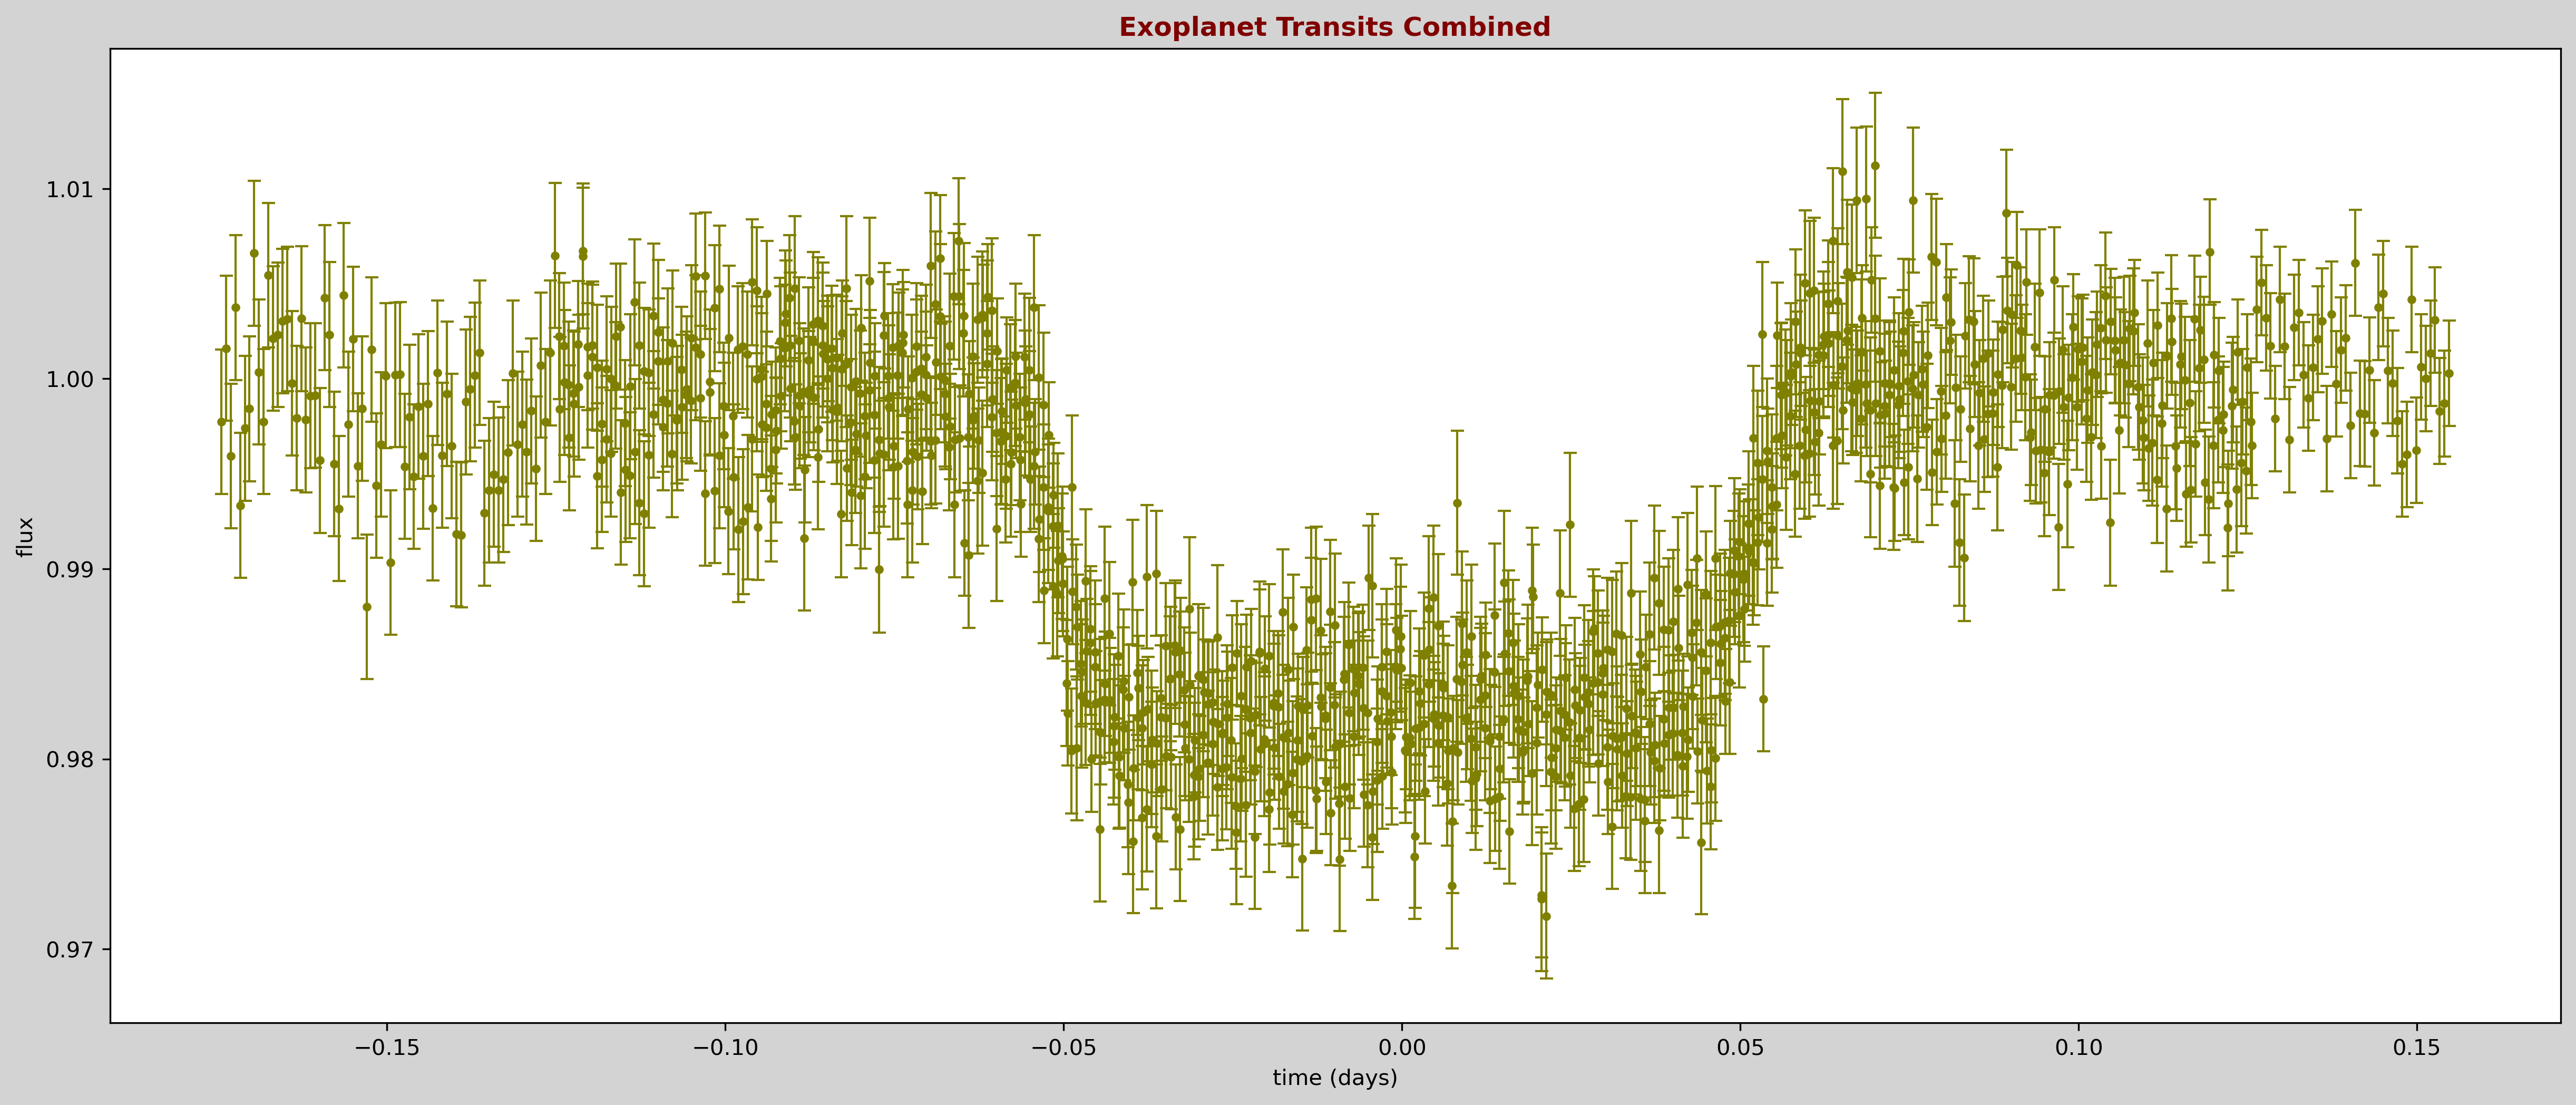

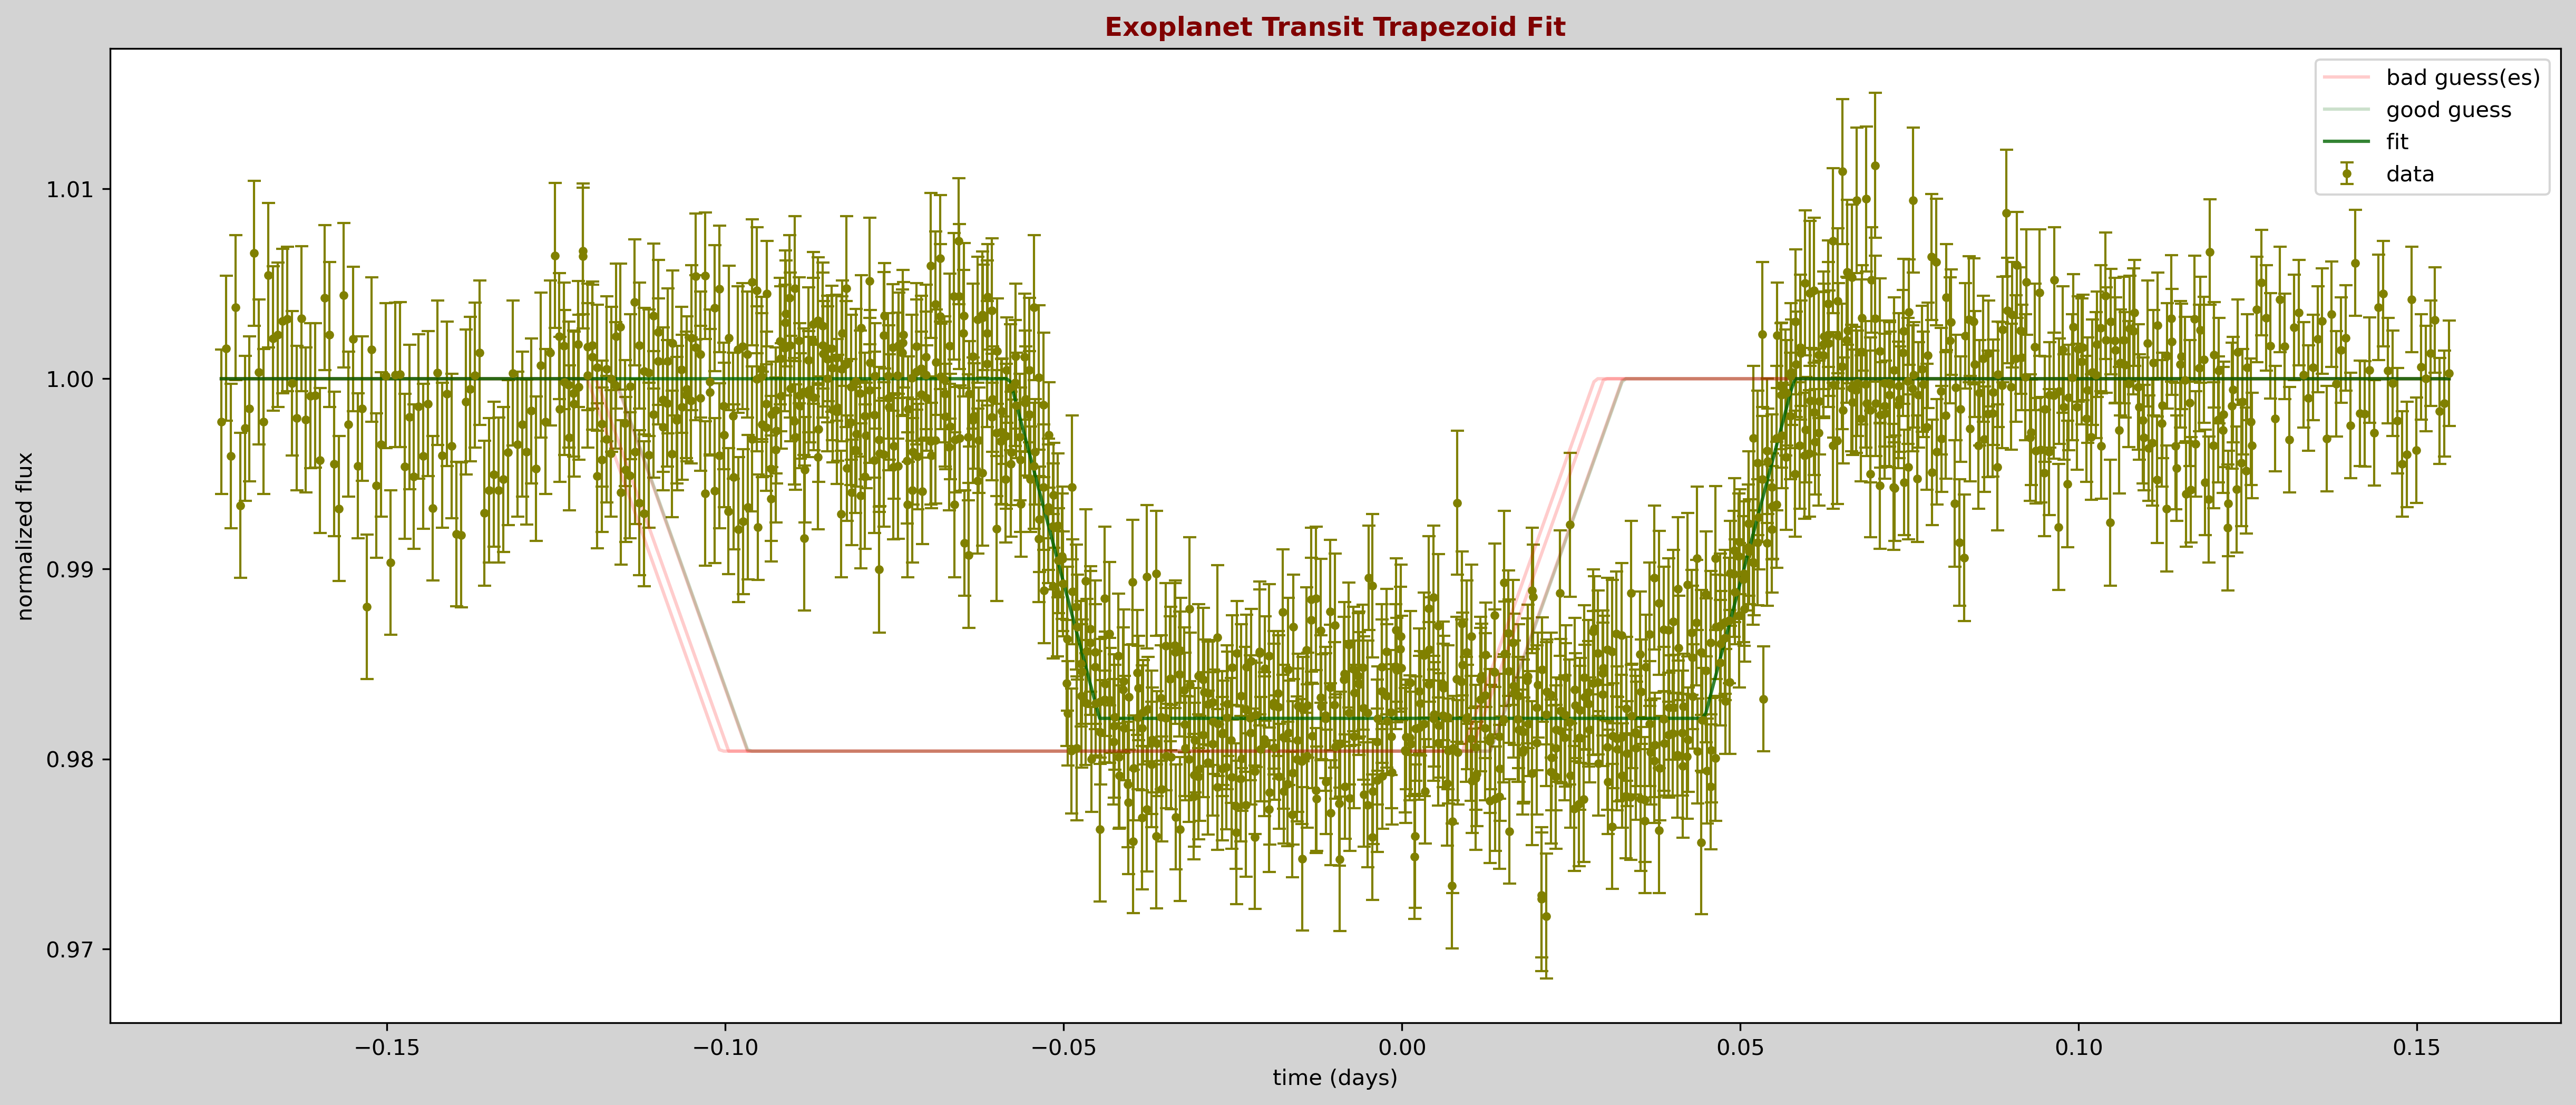

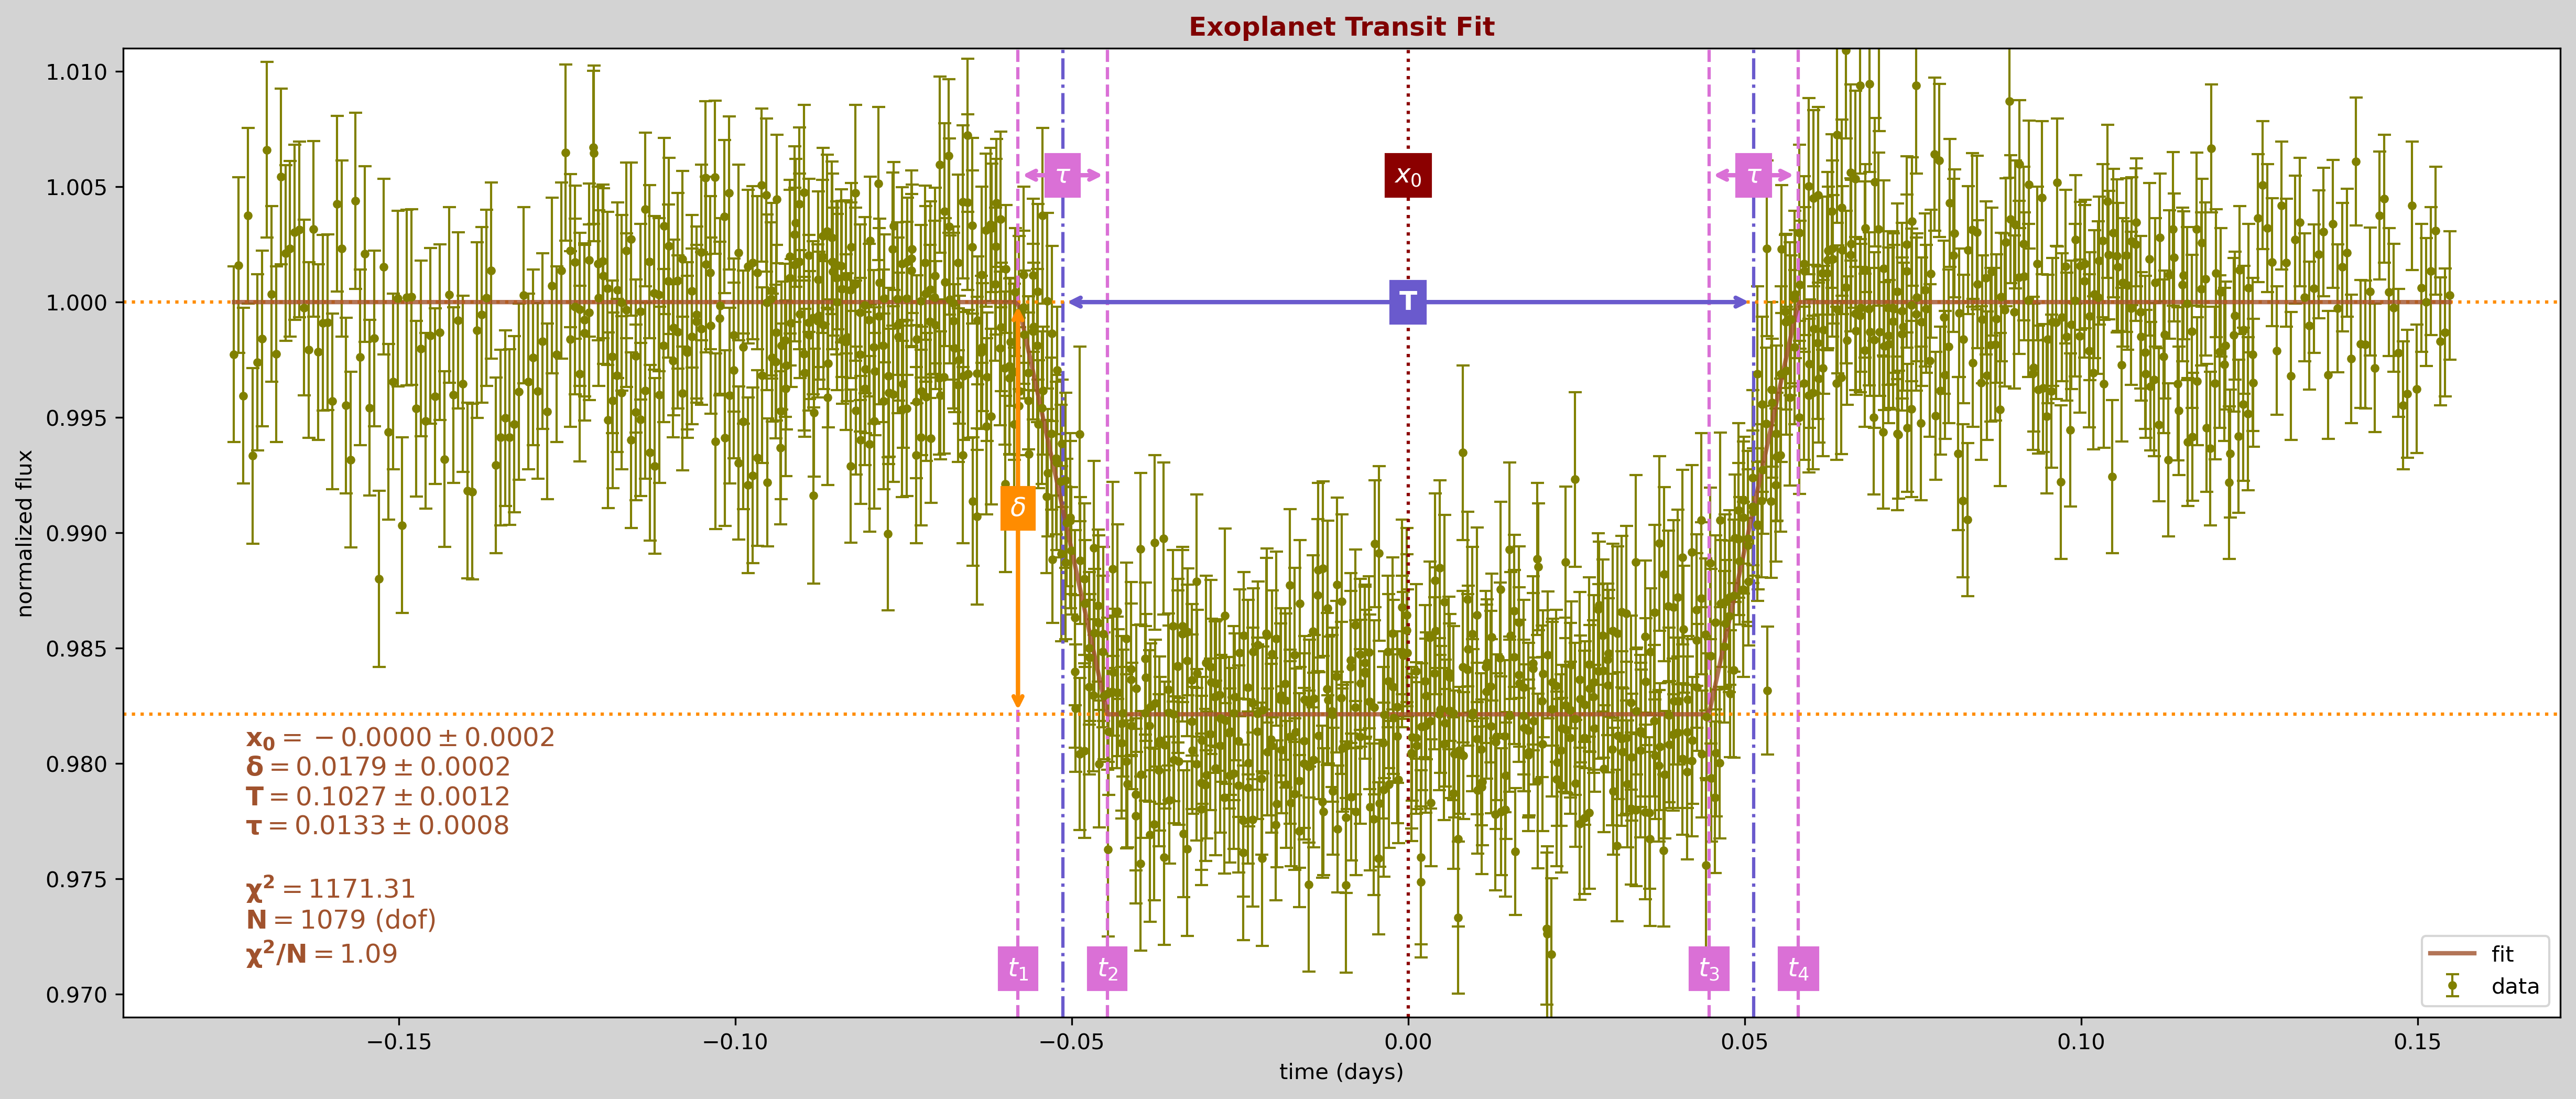

In [3]:
# combined analysis

# normalize and shift
time,flux,uncertainty = [],[],[]
for i,filename in enumerate(["hw3_prob1_data1.txt","hw3_prob1_data2.txt","hw3_prob1_data3.txt"]):
    time_,flux_,uncertainty_ = np.loadtxt(filename,skiprows=2).T
    time.append(time_-centers[i])
    flux.append(flux_/norms[i])
    uncertainty.append(uncertainty_/norms[i])
time = np.array(time).flatten()
flux = np.array(flux).flatten()
uncertainty = np.array(uncertainty).flatten()

flux = flux[np.argsort(time)]
uncertainty = uncertainty[np.argsort(time)]
time = time[np.argsort(time)]

fig,ax = plt.subplots(figsize = (20,8), dpi=300)
fig.set_facecolor("lightgray")
ax.set_title("Exoplanet Transits Combined",color="maroon",weight="bold")
ax.set_xlabel("time (days)")
ax.set_ylabel("flux")
ax.errorbar(time,flux,yerr=uncertainty,capsize=3,marker=".",ls='none',color="olive",label="data",lw=1)



fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)

inv_flux = -1*flux+1

fig,ax = plt.subplots(figsize = (20,8), dpi=300)
fig.set_facecolor("lightgray")
ax.set_title("Exoplanet Transit Trapezoid Fit",color="maroon",weight="bold")
ax.set_xlabel("time (days)")
ax.set_ylabel("normalized flux")
ax.errorbar(time,-1*(inv_flux-1),yerr=uncertainty,capsize=3,marker=".",ls='none',color="olive",label="data",lw=1)
# x0 seems to affect the fitting badly. iterate until it fits well
x0s = time[inv_flux>np.percentile(inv_flux,90)]
i = 0
red_chi2 = 10
cutoff = 1.5
labeled = False
while red_chi2 > cutoff and i < (len(x0s)):
    try:
        t_init = models.Trapezoid1D(amplitude=np.percentile(inv_flux,90),
                                    x_0=x0s[i],
                                    width=(np.max(time)-np.min(time))/3,
                                    slope=1)

        t = fitter(t_init,time,inv_flux,weights=1/uncertainty)
        errs = np.sqrt(np.diagonal(fitter.fit_info["cov_x"]))

        chi2 = np.sum(((t(time)-inv_flux)/uncertainty)**2)
        dof = len(time) - len(errs)
        red_chi2 = chi2/dof
        print(f"good guess; reduced chi^2: {red_chi2:.3f}")
        ax.plot(time,-1*(t_init(time)-1),color="darkgreen",alpha=0.2,label="good guess")
    except:
        print("bad guess")
        if labeled:
            ax.plot(time,-1*(t_init(time)-1),color="red",alpha=0.2)
        else:
            ax.plot(time,-1*(t_init(time)-1),color="red",alpha=0.2,label="bad guess(es)")
            labeled = True

    i += 1

ax.plot(time,-1*(t(time)-1),color="darkgreen",alpha=0.8,label="fit")
ax.legend()
plt.show()




fig,ax = plt.subplots(figsize = (20,8), dpi=300)
fig.set_facecolor("lightgray")
ax.set_title("Exoplanet Transit Fit",color="maroon",weight="bold")
ax.set_xlabel("time (days)")
ax.set_ylabel("normalized flux")
ax.set_ylim(0.969,1.011)
ax.errorbar(time,-1*(inv_flux-1),yerr=uncertainty,capsize=3,marker=".",ls='none',color="olive",label="data",lw=1)

ax.annotate('',xy=(t.x_0-t.width/2-t.amplitude/2*1/t.slope,1),xycoords='data',
                xytext=(t.x_0+t.width/2+t.amplitude/2*1/t.slope,1),textcoords='data',
                arrowprops=dict(color="slateblue",lw=2,arrowstyle="<->"),va='center')
ax.annotate('T',xy=(t.x_0*1.,1),xycoords='data',size=12,color="white",weight="bold",
            textcoords='data',ha="center",va="center",backgroundcolor="slateblue")
ax.axvline(t.x_0-t.width/2-t.amplitude/2*1/t.slope,color="slateblue",ls="-.")
ax.axvline(t.x_0+t.width/2+t.amplitude/2*1/t.slope,color="slateblue",ls="-.")

ax.axvline(t.x_0[0],color="darkred",ls=":")
ax.annotate('$x_0$',xy=(t.x_0[0],1+(ax.get_ylim()[-1]-1)/2),xycoords='data',size=12,color="white",weight="bold",
            textcoords='data',ha="center",va="center",backgroundcolor="darkred")


ax.annotate('',xy=(t.x_0-t.width/2-t.amplitude*1/t.slope,1+(ax.get_ylim()[-1]-1)/2),xycoords='data',
                xytext=(t.x_0-t.width/2,1+(ax.get_ylim()[-1]-1)/2),textcoords='data',
                arrowprops=dict(color="orchid",lw=2,arrowstyle="<->"),va='center')
ax.annotate('$\\tau$',xy=(t.x_0-t.width/2-t.amplitude/2*1/t.slope,1+(ax.get_ylim()[-1]-1)/2),xycoords='data',size=12,color="white",weight="bold",
            textcoords='data',ha="center",va="center",backgroundcolor="orchid")
ax.annotate('',xy=(t.x_0+t.width/2+t.amplitude*1/t.slope,1+(ax.get_ylim()[-1]-1)/2),xycoords='data',
                xytext=(t.x_0+t.width/2,1+(ax.get_ylim()[-1]-1)/2),textcoords='data',
                arrowprops=dict(color="orchid",lw=2,arrowstyle="<->"),va='center')
ax.annotate('$\\tau$',xy=(t.x_0+t.width/2+t.amplitude/2*1/t.slope,1+(ax.get_ylim()[-1]-1)/2),xycoords='data',size=12,color="white",weight="bold",
            textcoords='data',ha="center",va="center",backgroundcolor="orchid")
ax.axvline(t.x_0-t.width/2-t.amplitude*1/t.slope,color="orchid",ls="--")
ax.annotate('$t_1$',xy=(t.x_0-t.width/2-t.amplitude*1/t.slope,.95*ax.get_ylim()[0]+.05*ax.get_ylim()[-1]),xycoords='data',size=12,color="white",
            textcoords='data',ha="center",va="center",backgroundcolor="orchid")
ax.axvline(t.x_0+t.width/2+t.amplitude*1/t.slope,color="orchid",ls="--")
ax.annotate('$t_4$',xy=(t.x_0+t.width/2+t.amplitude*1/t.slope,.95*ax.get_ylim()[0]+.05*ax.get_ylim()[-1]),xycoords='data',size=12,color="white",
            textcoords='data',ha="center",va="center",backgroundcolor="orchid")
ax.axvline(t.x_0-t.width/2,color="orchid",ls="--")
ax.annotate('$t_2$',xy=(t.x_0-t.width/2,.95*ax.get_ylim()[0]+.05*ax.get_ylim()[-1]),xycoords='data',size=12,color="white",
            textcoords='data',ha="center",va="center",backgroundcolor="orchid")
ax.axvline(t.x_0+t.width/2,color="orchid",ls="--")
ax.annotate('$t_3$',xy=(t.x_0+t.width/2,.95*ax.get_ylim()[0]+.05*ax.get_ylim()[-1]),xycoords='data',size=12,color="white",
            textcoords='data',ha="center",va="center",backgroundcolor="orchid")

ax.annotate('',xy=(t.x_0-t.width/2-t.amplitude*1/t.slope,1),xycoords='data',
                xytext=(t.x_0-t.width/2-t.amplitude*1/t.slope,1-t.amplitude),textcoords='data',
                arrowprops=dict(color="darkorange",lw=2,arrowstyle="<->"),va='center')
ax.annotate('$\\delta$',xy=(t.x_0-t.width/2-t.amplitude*1/t.slope,(1-t.amplitude/2)),xycoords='data',size=12,color="white",weight="bold",
            textcoords='data',ha="center",va="center",backgroundcolor="darkorange")
ax.axhline(1,color="darkorange",ls=":")
ax.axhline(1-t.amplitude,color="darkorange",ls=":")

textfit = '$\\mathbf{{x_0}} = {:.4f} \\pm {:.4f}$ \n'.format(t.x_0[0],
                                                             errs[1]) 
textfit += '$\\mathbf{{\\delta}} = {:.4f} \\pm {:.4f}$ \n'.format(t.amplitude[0],
                                                                  errs[0]) 
textfit += '$\\mathbf{{T}} = {:.4f} \\pm {:.4f}$ \n'.format(t.width+t.amplitude*1/t.slope,
                                                            (errs[2]**2+(t.amplitude*1/t.slope*((errs[0]/t.amplitude)**2+(errs[3]/t.slope)**2)**0.5)**2)**0.5) 
textfit += '$\\mathbf{{\\tau}} = {:.4f} \\pm {:.4f}$ \n\n'.format(t.amplitude*1/t.slope,
                                                                  t.amplitude*1/t.slope*((errs[0]/t.amplitude)**2+(errs[3]/t.slope)**2)**0.5) 
textfit += '$\\mathbf{{\\chi^2}}= {:.2f}$ \n'.format(chi2)
textfit += '$\\mathbf{{N}} = {}$ (dof) \n'.format(dof) 
textfit += '$\\mathbf{{\\chi^2/N}} = {:.2f}$'.format(red_chi2)
ax.text(0.05, 0.05,textfit,transform=ax.transAxes,fontsize=12,verticalalignment='bottom',horizontalalignment='left',color="sienna")

ax.plot(time,-1*(t(time)-1),color="sienna",alpha=0.8,label="fit",lw=2)
ax.legend(loc="lower right")

plt.show()

---

<span style="color:orange">

### observables

In [4]:
delta = t.amplitude[0]
delta_err = errs[0]
T = t.width+t.amplitude*1/t.slope
T_err = (errs[2]**2+(t.amplitude*1/t.slope*((errs[0]/t.amplitude)**2+(errs[3]/t.slope)**2)**0.5)**2)**0.5
tau = t.amplitude*1/t.slope
tau_err = t.amplitude*1/t.slope*((errs[0]/t.amplitude)**2+(errs[3]/t.slope)**2)**0.5

In [5]:
print(f"delta: {delta:.4f} ± {delta_err:.4f} %")
print(f"T: {T:.4f} ± {T_err:.4f} days")
print(f"tau: {tau:.4f} ± {tau_err:.4f} days")

delta: 0.0179 ± 0.0002 %
T: 0.1027 ± 0.0012 days
tau: 0.0133 ± 0.0008 days


<span style="color:orange">

### orbital period

best of 10000 combinations: [0, 2, 5]


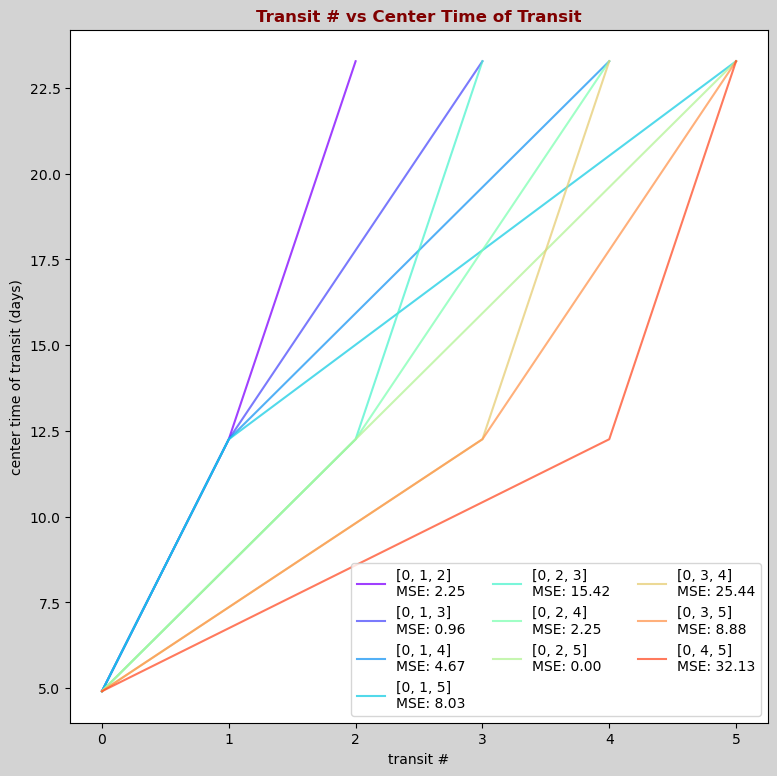

In [6]:
# we have the centers of certain transits,
# but are not given whether the transits are consecutive
# can test many combinations of [0,i,j]
transits_coll = []
maxnum = 100
for i in np.arange(maxnum+1):
    for j in np.arange(maxnum+1+i):
        if j>i and i>0:
            transits_coll.append([0,i,j])
mses = []
for i,transits in enumerate(transits_coll):
    mses.append(np.polyfit(transits,centers,1,full=True)[1][0])
print(f"best of {len(transits_coll)} combinations: {transits_coll[np.argmin(mses)]}")



transits_coll = []
maxnum = 5
for i in np.arange(maxnum+1):
    for j in np.arange(maxnum+1):
        if j>i and i>0:
            transits_coll.append([0,i,j])

fig,ax = plt.subplots(figsize = (9,9))
fig.set_facecolor("lightgray")
ax.set_title("Transit # vs Center Time of Transit",color="maroon",weight="bold")
ax.set_xlabel("transit #")
ax.set_ylabel("center time of transit (days)")
colors = plt.get_cmap("rainbow")(np.linspace(0,.9,len(transits_coll)))
for i,transits in enumerate(transits_coll):
    fit,res,_,_,_ = np.polyfit(transits,centers,1,full=True)
    ax.plot(transits,centers,color=colors[i],label=f'{transits}\nMSE: {res[0]:.2f}',alpha=0.75)
    # plt.plot(transits,np.poly1d(np.polyfit(transits,centers,1))(transits),color=colors[i],label=str(transits))
ax.legend(ncol=3)
plt.show()

In [7]:
# best chi^2 of separate transit fits is [0,2,5]
P = np.polyfit([0,2,5],centers,1)[0]
P_err = (centers_err[2]**2+centers_err[0]**2+centers_err[1]**2)**0.5

print(f'orbital period: {P:.4f} ± {P_err:.4f}')
print("\nother orbital period calculations:")
print((centers[2]-centers[0])/5)
print((centers[2]-centers[1])/3)
print((centers[1]-centers[0])/2)
print("consistent with error!")

orbital period: 3.6735 ± 0.0007

other orbital period calculations:
3.6735343357969215
3.6736415587742157
3.67337350133098
consistent with error!


<span style="color:orange">

### $R_p/R_s$

$(R_p/R_s)^2 = k^2 = \delta$

In [8]:
# we have delta, just need to square root and propagate uncertainty
k = t.amplitude[0]**0.5
k_err = 0.5*(errs[0]/t.amplitude[0])
print(f"R(p)/R(s) = k = {k:.3f} ± {k_err:.3f}")

R(p)/R(s) = k = 0.134 ± 0.005


<span style="color:orange">

### impact parameter

theoretically, the impact parameter should be 0 if there is no limb darkening.

$b_{tra} = \frac{a*cos(i)}{R_{star}}$ OR $b^2 = 1-\sqrt{\delta}\frac{T}{\tau}$ from observables

In [9]:
(1-delta**0.5*T/tau)

-0.03434833333040288

b should be the square root of this negative, so will go with theory that suggests 0. the errors in the parameters could cause this number to be around 0.

<span style="color:orange">

### $a/R_{s}$

assuming impact of 0, eccentricity of 0, and inclination of 90...

$T = \frac{R_sP}{\pi a} \implies \frac{a}{R_s} = \frac{P}{\pi T}$

In [10]:
ratio_a_Rs = P/(np.pi*T)
ratio_a_Rs_err = 1/np.pi * ratio_a_Rs*((P_err/P)**2+(T_err/T)**2)**0.5

In [11]:
print(f"a/Rs = {ratio_a_Rs:.2f} ± {ratio_a_Rs_err:.2f}")

a/Rs = 11.39 ± 0.04


<span style="color:orange">

### orbital inclination

we assume orbital inclination to be 90 (edge-on), given there is no limb darkening

<span style="color:orange">

### planet mass

$M_p = \frac{M_s^{2/3}K\sqrt{1-e^2}}{sin(i)}(\frac{P}{2\pi G})^{1/3} = M_s^{2/3}K(\frac{P}{2\pi G})^{1/3}$  
note that P needs to be converted to seconds

In [12]:
mass_p = (0.9*1.98e30)**(2/3)*(141.24)*(P*86400/(2*np.pi*6.67e-11))**(1/3)
mass_p_err = (0.9*1.98e30)**(2/3)*(141.24)*(86400/(2*np.pi*6.67e-11))**(1/3)*1/3*P_err/P

In [13]:
print(f"planet mass: {mass_p/1e27:.5f}e27 ± {mass_p_err/1e27:.5f}e27 kg")
print(f"practically negligable error!")

planet mass: 1.89232e27 ± 0.00008e27 kg
practically negligable error!


<span style="color:orange">

### a for orbit; kepler's third law

$P^2 = \frac{4\pi^2}{GM}a^3 \implies a = [\frac{GM_sP^2}{4\pi^2}]^{1/3}$

In [14]:
a_orbit = ((6.67e-11*(0.9*1.98e30)*(P*86400)**2)/(4*np.pi**2))**(1/3)
a_orbit_err = ((6.67e-11*(0.9*1.98e30)*(86400)**2)/(4*np.pi**2))**(1/3)*2/3*(P_err/P)

In [15]:
print(f"orbital radius: {a_orbit/1e9:.4f}e9 ± {a_orbit_err/1e9:.4f}e9 m")

orbital radius: 6.7188e9 ± 0.0004e9 m


<span style="color:orange">

### radius of star

$\frac{a}{R_s} \implies R_s = a/\frac{a}{R_s}$

In [16]:
star_rad = a_orbit/ratio_a_Rs
star_rad_err = star_rad*((a_orbit_err/a_orbit)**2+(ratio_a_Rs_err/ratio_a_Rs)**2)**0.5

In [17]:
print(f"star radius: {star_rad/1e8:.2f}e8 ± {star_rad_err/1e8:.2f}e8 m")

star radius: 5.90e8 ± 0.02e8 m


<span style="color:orange">

### radius of planet

$k = (R_p/R_s) \implies R_p = kR_s$

In [18]:
plan_rad = k*star_rad
plan_rad_err = plan_rad*((k_err/k)**2+(star_rad_err/star_rad)**2)**0.5

In [19]:
print(f"planet radius: {plan_rad/1e7:.1f}e7 ± {plan_rad_err/1e7:.1f}e7 m")

planet radius: 7.9e7 ± 0.3e7 m


<span style="color:orange">

### density of star

$\rho_s = \frac{3\pi}{GP^2}(\frac{a}{R_s})^3$

In [20]:
star_dens = 3*np.pi/(6.67e-11*(P*86400)**2)*(ratio_a_Rs)**3
star_dens_err = 3*np.pi/(6.67e-11*(P*86400)**2)*3*(ratio_a_Rs_err/ratio_a_Rs)

In [21]:
print(f"density of star: {star_dens:.3f} ± {star_dens_err:.3f} kg/m^3")

density of star: 2071.267 ± 0.016 kg/m^3


<span style="color:orange">

### surface gravity of planet

$g_p = \frac{2\pi}{P}\frac{\sqrt{1-e^2}K}{(R_p/a)^2sin(i)} = \frac{2\pi K}{P}(\frac{a}{R_p})^2$

In [22]:
surf_grav = 2*np.pi*141.24/(86400*P)*(a_orbit/plan_rad)**2
surf_grav_err = 2*np.pi*141.24/(86400*P_err)*(a_orbit_err/plan_rad_err)**2

In [23]:
print(f"surface gravity of planet: {surf_grav:.1f} ± {surf_grav_err:.1f} m/s^2")

surface gravity of planet: 20.3 ± 0.3 m/s^2


---